# Homework 2

### Homework 2 informations

In this homework, you are invited to solve an image classification problem to learn the behaviour of a racing car in a Gym environment [1].

The dataset (divided into training and test sets) contains 96x96 color images labelled with one out of the 5 actions available for the control of the car. 

The dataset is provided as sets of images organized in folders labelled with the id of the action.  
https://drive.google.com/drive/folders/1bNL8icEqHNswHJfmhPsEcoxHy2zonAGd

Requirements on methodology and results:
- define your own model based on CNN (do not use pre-defined architectures or pre-trained models)
 - solve the problem using 2 different approaches. By approaches, we mean architectures, optimizers, regularizations, preprocessing, etc., not just different values of the hyperparameters.
- report analysis of fundamental metrics, such as accuracy, f1, precision, and recall. Screenshoots of the output of some model is not sufficient. You must elaborate the results providing better visualizations and specific comments.
- conduct an analysis of at least one hyperparameter in relation to the chosen metrics.

In practice, you have to define two different approaches, train them with different hyperparameters, compare them (performance vs hyperparameter), visualize the results in proper forms (figures, tables), and discuss the results.
Any software library can be used, including Python (tensorflow or pytorch), MATLAB, etc.

The output of the assignment should be:
1) A PDF report (no other format is accepted) of about 10 pages, with your name and matricola code) describing the implemented solution: data pre-processing (if any), the exact model (with all the layers) that has been designed, the chosen optimizer, hyperparameter tuning, description of the evaluation method, comparative results using appropriate metrics, including training time, and discussion about the results. Conclusions should discuss the comparative results. 
2) A ZIP file with the code you used in the project (not including the dataset)
3) [optional] a video (or a link to a video) showing the execution of the learned function as the policy driving the racing car on some tracks in the Gym environment (see the snippet of code in the dataset folder).

Submit the files through this assignment (other submission methods, such as e-mail, will not be accepted). Make sure to turn the assignment in, otherwise it will not reach the teachers. 
NOTE: do not put the PDF report into the ZIP file!!! 

This assignment must be individual (i.e., one submission for each student) and original (i.e., not equal or too similar to other works either from other students in this class or from other sources). Evaluation will be based on the appropriateness and correctness of the described solution, regardless of the numeric results (as long as they are reasonable).

Deadline: 14/1/2024 11:59 PM CET

[1] https://gymnasium.farama.org/environments/box2d/car_racing/

# Dataset loading

For this homework we are going to use PyTorch as main framework. We are going to use the `torchvision` library to load the dataset. The dataset is composed by 5 classes, each one representing a different action for the car. The dataset is composed by 5 classes, each one representing a different action for the car. The classes are:
- 0: left
- 1: right
- 2: accelerate
- 3: brake
- 4: do nothing

Let's import the libraries we are going to use.

In [1]:
import torch
import torch.nn as nn
import torchmetrics
import torchvision.transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

from torch import nn
from torchvision import datasets, transforms

from torchsampler import ImbalancedDatasetSampler

from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

added_size = 8.0
plt.rcParams['figure.figsize'] = [6.4 + added_size, 4.8 + added_size]

For this porpouse we are going to use the `ImageFolder` class from `torchvision.datasets` library. This class is used to load the dataset from a specific folder structure that is followed by the given dataset.

In [2]:
# Training set
full_train_dataset = datasets.ImageFolder(
    root='dataset/train',
    transform=transforms.ToTensor()
)

# Dimension of the training set and validation set
train_size = len(full_train_dataset)
validation_fraction = 0.2  # ad esempio, 20% dei dati per la validazione

# Calculate the size of the training set and validation set
validation_size = int(train_size * validation_fraction)
training_size = train_size - validation_size

# Split the dataset into training set and validation set
train_dataset, validation_dataset = random_split(full_train_dataset, [training_size, validation_size])

# Test set
test_dataset = datasets.ImageFolder(
    root='dataset/test',
    transform=transforms.ToTensor()
)

Now we are going to ispectionate the dataset and see how many classes we have and the size of on image of the dataset. Then we are going to check if the dataset is balanced making a bar plot of the number of images for each class.

Classes:  ['0', '1', '2', '3', '4']
Elements for class:  tensor([1000, 1500, 1500, 2000,  369])
Images shape:  torch.Size([3, 96, 96])


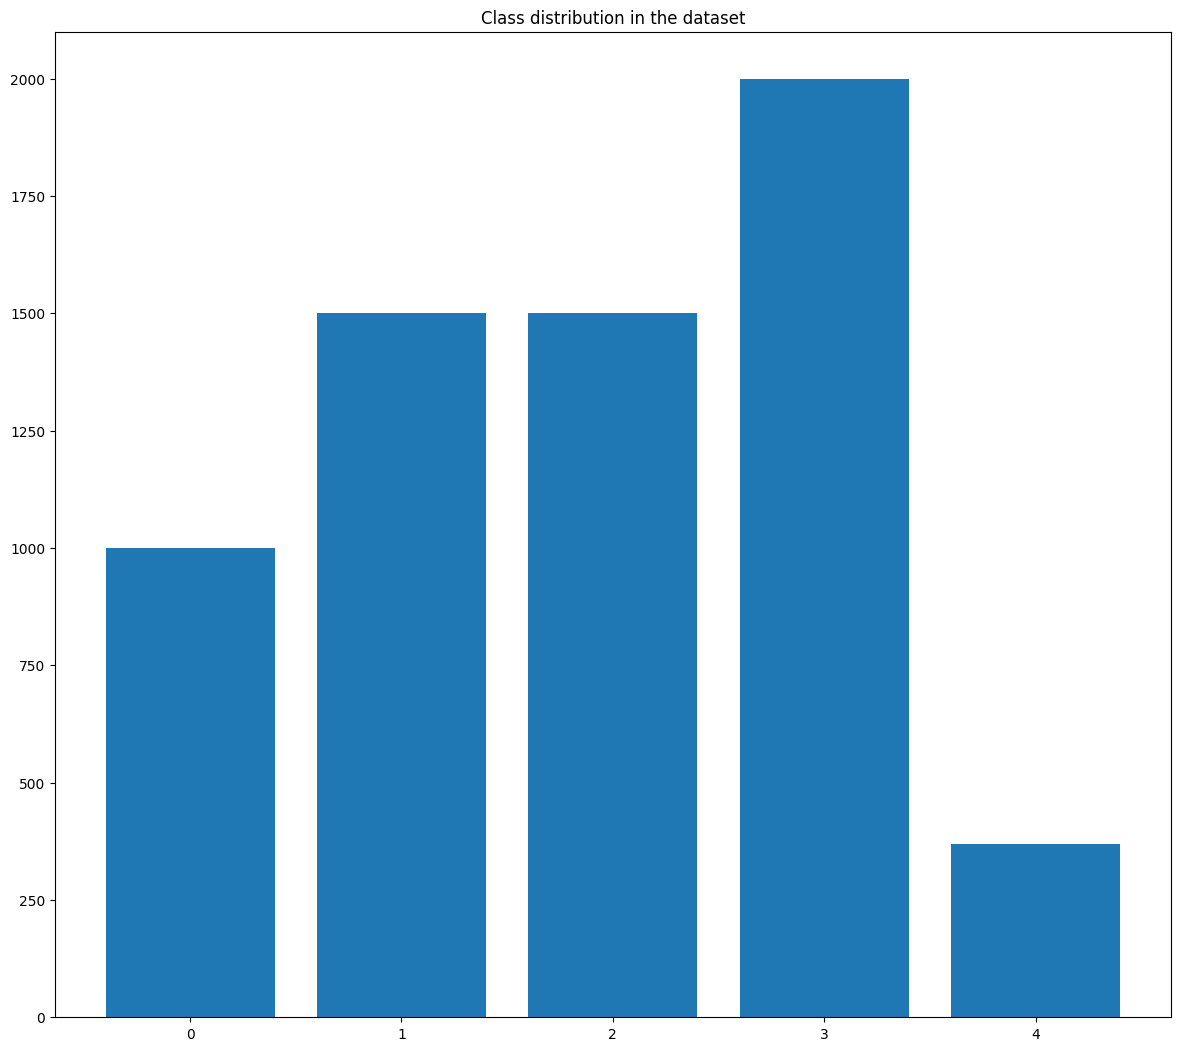

In [3]:
# Counting the number of elements for each class
elemements_for_class = torch.unique(torch.IntTensor(full_train_dataset.targets), return_counts=True)[1]

# Printing some information about the dataset
print("Classes: ", full_train_dataset.classes)
print("Elements for class: ", elemements_for_class)
print("Images shape: ", full_train_dataset[0][0].shape)

# Plotting the class distribution
plt.bar(full_train_dataset.classes, elemements_for_class) # Plotting the class distribution
plt.title('Class distribution in the dataset') # Adding title to the plot
plt.show()

Let's show an image for each class.

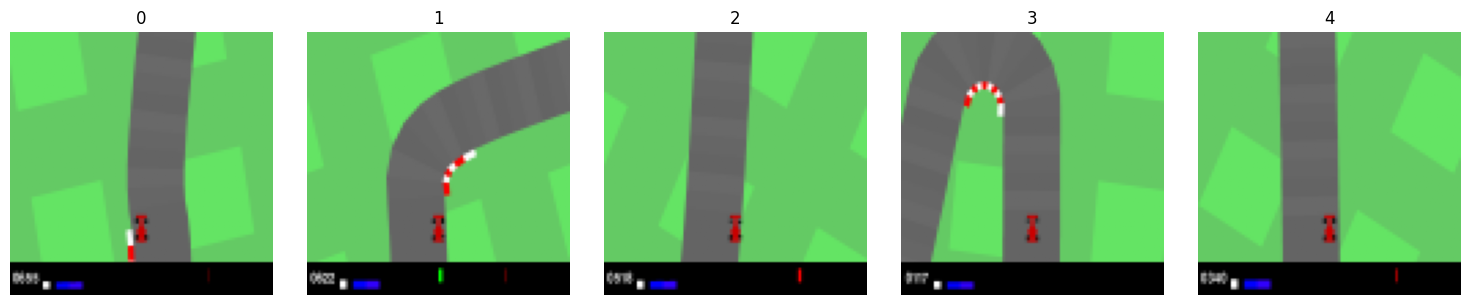

In [4]:
# Create the plot
fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Create a figure containing 5 subplots

# For each image in the training set plot it
printed_classes = set()  # Set of printed classes
for image, label in train_dataset:
    if label not in printed_classes:
        axs[len(printed_classes)].imshow(image.permute(1, 2, 0))  # Show the image
        axs[len(printed_classes)].set_title(label)  # Set the title of the subplot
        axs[len(printed_classes)].axis('off')  # Disable the axis
        printed_classes.add(label) # Add the class to the set of printed classes

    if len(printed_classes) == 5:  # If all the classes have been printed break
        break

# Show the figure
plt.tight_layout()  # Make the subplots fit in the figure properly
plt.show() 

The class 3 has 2000 elements, so we are going to check how many elements we need to add to the other classes to balance the dataset. We are going to make a Data Augmentation to balance the dataset. We are going to use the `torchvision.transforms` library to make the Data Augmentation. We are going to use the `RandomRotation` to make the Data Augmentation.

In [5]:
# Dictionary to store class counts
keys = [0, 1, 2, 3, 4]
values = elemements_for_class.tolist()

# Dictionary to store class counts 
class_counts = { k:v for (k,v) in zip(keys, values)}  

# Define data transformations for data augmentation
augmentation_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    # original dimension = 96x96x3
    transforms.Resize((96, 96), antialias=True),
])

# Create an empty list to store augmented datasets for each class
augmented_datasets = []

# Iterate over classes
for class_idx in range(5):
    
    print("Iterating over class: ", class_idx)

    # Calculate the number of additional samples needed
    num_additional_samples = 2000 - class_counts[class_idx]

    # Create an additional dataset with augmented samples for the current class
    augmented_samples = []
    
    class_dataset = [sample for sample in train_dataset if sample[1] == class_idx]

    for i in range(num_additional_samples):
        # Randomly select an image from the original class dataset
        image, label = class_dataset[random.randint(0, len(class_dataset) - 1)]

        # Apply data augmentation
        augmented_image = augmentation_transform(image)

        # Append the augmented sample to the list
        augmented_samples.append((augmented_image, label))

    # Update class counts
    class_counts[class_idx] += num_additional_samples

    # Concatenate the original and additional datasets
    augmented_datasets.extend(augmented_samples)

# Combine the original and augmented datasets
augmented_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_datasets])


Iterating over class:  0
Iterating over class:  1
Iterating over class:  2
Iterating over class:  3
Iterating over class:  4


Let's check if the dataset is balanced now.

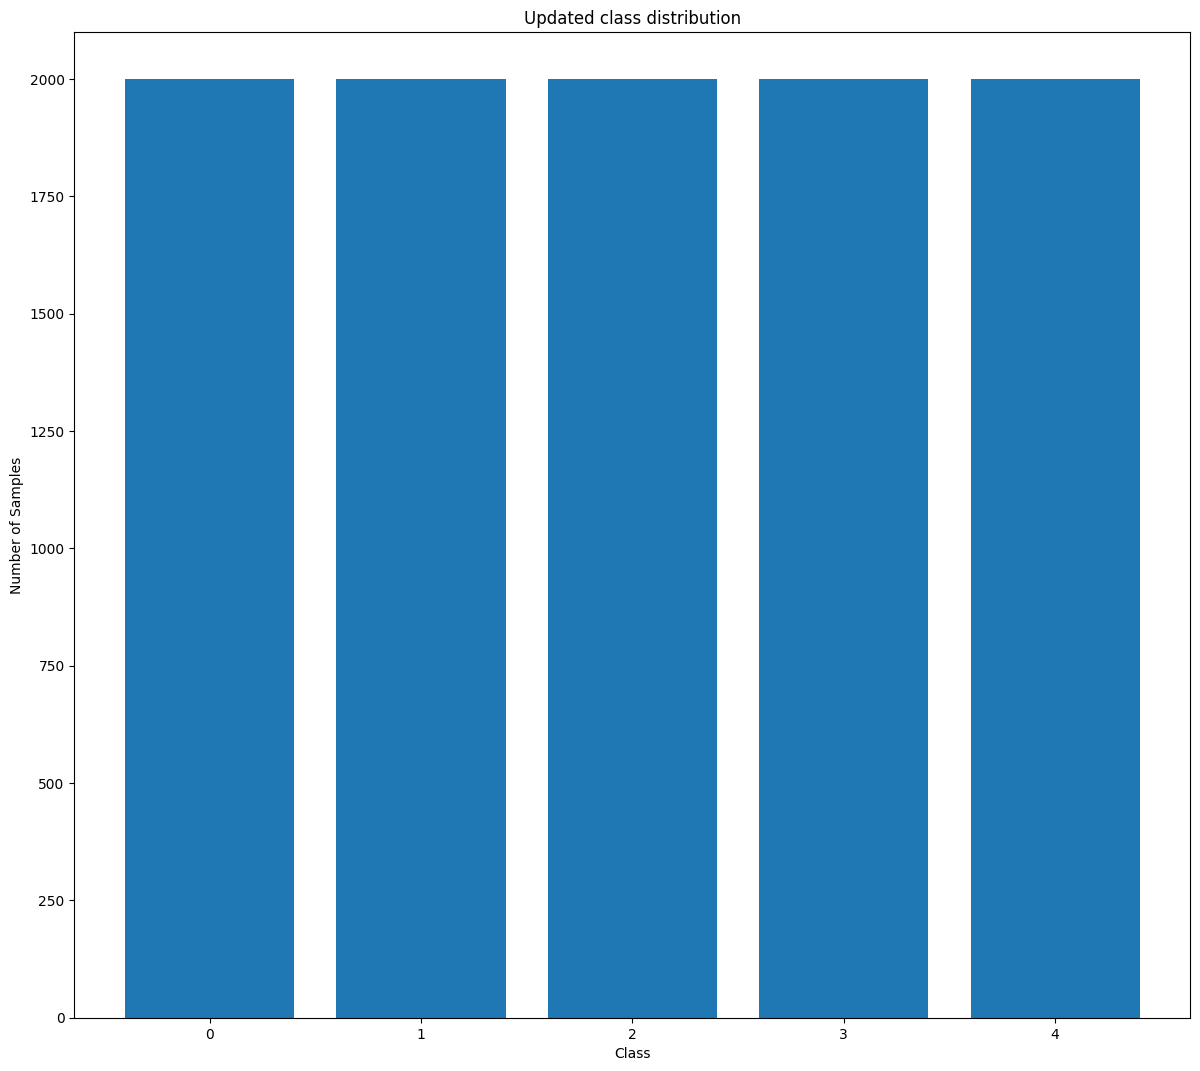

In [6]:
# Plot and show a bar chart of the updated class counts
class_labels, counts = zip(*class_counts.items()) # Unpack the dictionary into two lists
plt.bar(class_labels, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Updated class distribution')
plt.show()

We define a SimpleCNN class that inherits from nn.Module.

In [7]:
# Definition of the SimpleCNN model
class SimpleCNN(nn.Module):  
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # INPUT IMAGE SIZE: 96x96x3
        # CONVOLUTION OUTPUT SIZE FORMULA: (W - K + 2P) / S + 1
        
        # First conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2) # (96 - 5 + 2*2) / 2 + 1 = 48
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2) # (48 - 3) / 2 + 1 = 24

        # Second conv layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=2) # (24 - 3 + 2*2) / 2 + 1 = 13
        # after applying pool: (12 - 3) / 2 + 1 = 6
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 120)
        self.fc3 = nn.Linear(120, 5)  # 5 output classes

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the output of the convolutional layers
        x = torch.flatten(x,1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        
        # Output layer
        x = self.fc3(x)

        return x

We define an AdancedCNN class that inherits from nn.Module.

In [8]:
# Definition of the SimpleCNN model
class AdvancedCNN(nn.Module):  
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        
        # INPUT IMAGE SIZE: 96x96x3
        # CONVOLUTION OUTPUT SIZE FORMULA: (W - K + 2P) / S + 1
        
        # First conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2) # (96 - 5 + 2*2) / 2 + 1 = 48
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # (48 - 2) / 2 + 1 = 24

        # Second conv layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # (24 - 3 + 2*1) / 1 + 1 = 24
        # after applying pool: (24 - 2) / 2 + 1 = 12

        # Third conv layer
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) # (12 - 3 + 2*1) / 1 + 1 = 12
        
        # after applying pool: (12 - 2) / 2 + 1 = 6

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 5)  # 5 output classes

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output of the convolutional layers
        x = torch.flatten(x,1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Output layer
        x = self.fc3(x)

        return x

Since we are using Pytorch we are going to instanciate a `torch.utils.data.DataLoader` object that is used to load the dataset in batches. This object is used to iterate over the dataset in batches and it is very useful when we have a large dataset.

In [9]:
# Definition of the load_data function
def load_data(train_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size)
    test_loader = DataLoader(test_dataset, batch_size)
    return train_loader, validation_loader, test_loader

Now that we have defined the model we are going to train it. To do this we are going to use the `train_model` function. This function is used to train the model for a given number of epochs. For each epoch we are going to iterate over the dataset and for each batch we are going to compute the loss and the accuracy of the model. After that we are going to compute the gradients and update the weights of the model.

Since we want to track the performance of the model during the training we are going to track the loss and the accuracy both for the training and the validation set. This is useful to see if the model is overfitting or not. If the model is overfitting the training loss will decrease while the validation loss will increase. This is due to the fact that the model is learning the training set and it is not able to generalize to the validation set.

In [11]:
import time
# Definition of the train_model function
def train_model(model, train_loader, validation_loader, num_epochs, optimizer):
    
    # Initialize accuracy metrics
    accuracy_metric = torchmetrics.Accuracy(num_classes=5, task='multiclass')
    validation_accuracy_metric = torchmetrics.Accuracy(num_classes=5, task='multiclass')

    # Initialize metrics history lists
    loss_history, accuracy_history = [], []
    validation_loss_history, validation_accuracy_history = [], []

    batch_number = 1

    print("Training...")
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        for inputs, labels in train_loader:   
            
            # Take the current time as starting time
            start_time = time.time()
            
            # Reset gradients, compute outputs, compute loss, compute gradients, update weights
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update accuracy metric
            accuracy_metric.update(outputs, labels) 
            
            # Update loss and accuracy history
            accuracy_history.append(accuracy_metric.compute().item())
            loss_history.append(loss.item()) 
            
            # Print current batch number and loss
            if (batch_number % 16 == 0): 
                print("Batch number: ", batch_number, "/", len(train_loader)*num_epochs)
                print("Current loss: ", loss.item())
            
                # Print elapsed time
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", elapsed_time)    
                
                # Print estimated time
                estimated_time = elapsed_time * (len(train_loader)*num_epochs - batch_number)
                print("Estimated time: ", estimated_time)
            
            # Update batch number
            batch_number += 1;   

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        
        with torch.no_grad():
            for inputs, labels in validation_loader:
                
                # Compute outputs and loss
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                
                # Update validation accuracy metric
                validation_accuracy_metric.update(outputs, labels)
                
                # Update validation loss and accuracy history
                validation_accuracy_history.append(validation_accuracy_metric.compute().item())
                validation_loss_history.append(loss.item())
                        
        # Print epoch results
        print(f"Epoch {epoch + 1}, Training Loss: {loss_history[-1]}, Validation Loss: {validation_loss_history[-1]}")
        print(f"Epoch {epoch + 1}, Training Accuracy: {accuracy_history[-1]}, Validation Accuracy: {validation_accuracy_history[-1]}")

    return loss_history, accuracy_history, validation_loss_history, validation_accuracy_history


We define a test_model use to compute all the metrics for the test set. This function is used to compute the accuracy, the precision, the recall, the f1 score and the confusion matrix for the test set. 

In [10]:
# Definition of the test_model function
def test_model(model, test_loader):
    
    # Inizialize metrics and confusion matrix
    accuracy_metric = torchmetrics.Accuracy(num_classes=5, task='multiclass')
    precision_metric = torchmetrics.Precision(num_classes=5, average='weighted', task='multiclass')
    recall_metric = torchmetrics.Recall(num_classes=5, average='weighted', task='multiclass')
    f1_metric = torchmetrics.F1Score(num_classes=5, average='weighted', task='multiclass')
    confusion_matrix_metric = torchmetrics.ConfusionMatrix(num_classes=5, task='multiclass')

    batch_number = 1;

    print("Testing...")

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking
        for data in test_loader:     
            
            # Print current batch number
            if (batch_number % 16 == 0): print("Batch number: ", batch_number, "/", len(test_loader))
            
            images, labels = data
            images, labels = images, labels
            outputs = model(images)

            # Update metrics and confusion matrix
            accuracy_metric.update(outputs, labels)
            precision_metric.update(outputs, labels)
            recall_metric.update(outputs, labels)
            f1_metric.update(outputs, labels)
            confusion_matrix_metric.update(outputs, labels)
            
            batch_number += 1;

    # Calculate metrics and confusion matrix
    test_accuracy = accuracy_metric.compute().item()
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1 = f1_metric.compute().item()
    confusion_matrix = confusion_matrix_metric.compute().cpu().numpy()
    
    # Print metrics and confusion matrix
    print(f"Accuracy: {test_accuracy * 100}%")
    print(f"Precision: {test_precision * 100}%")
    print(f"Recall: {test_recall * 100}%")
    print(f"F1 Score: {test_f1 * 100}%")
    print("Confusion Matrix:\n", confusion_matrix)

    return test_accuracy, test_precision, test_recall, test_f1, confusion_matrix

We define a function to plot the loss and the accuracy of the model during the training. This function is used to plot the loss and the accuracy of the model during the training. This is useful to see if the model is overfitting or not. If the model is overfitting the training loss will decrease while the validation loss will increase. This is due to the fact that the model is learning the training set and it is not able to generalize to the validation set.

In [12]:
# Definition of the plot_metrics function
def plot_metrics(loss_history, validation_loss_history, accuracy_history, validation_accuracy_history, confusion_matrix):
    # Set a grid of 2x2 subplots
    fig, axs = plt.subplots(2, 2)

    # Graph of the training loss
    axs[0, 0].plot(range(1, len(loss_history) + 1), loss_history, 'r', label='Training Loss')
    axs[0, 0].set_title('Training Loss')
    axs[0, 0].set_xlabel('Batches')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    #  Graph of the validation loss
    axs[0, 1].plot(range(1, len(validation_loss_history) + 1), validation_loss_history, 'b', label='Validation Loss')
    axs[0, 1].set_title('Validation Loss')
    axs[0, 1].set_xlabel('Batches')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()

    # Graph of the training accuracy
    axs[1, 0].plot(range(1, len(accuracy_history) + 1), accuracy_history, 'g', label='Training Accuracy')
    axs[1, 0].set_title('Training Accuracy')
    axs[1, 0].set_xlabel('Batches')
    axs[1, 0].set_ylabel('Accuracy')
    axs[1, 0].legend()

    # Graph of the validation accuracy
    axs[1, 1].plot(range(1, len(validation_accuracy_history) + 1), validation_accuracy_history, 'm', label='Validation Accuracy')
    axs[1, 1].set_title('Validation Accuracy')
    axs[1, 1].set_xlabel('Batches')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    # Show the figure
    plt.tight_layout()
    plt.show()

    # Plot the confusion matrix
    im = plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar(im)
    tick_marks = np.arange(confusion_matrix.shape[0])
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    # Add the confusion matrix values inside the plot
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                    horizontalalignment='center',
                    color='white' if confusion_matrix[i, j] > confusion_matrix.max() / 2. else 'black')

    # Show the figure
    plt.show()

Let's train the SimpleCNN model making a grid search to find the best hyperparameters.

Models to train:  1

Training model number:  0
Epochs:  5  Batch size:  64  Learning rate:  0.001

Training...


Batch number:  16 / 685
Current loss:  1.5834492444992065
Elapsed time:  0.10258793830871582
Estimated time:  68.63133072853088
Batch number:  32 / 685
Current loss:  1.3988271951675415
Elapsed time:  0.10702061653137207
Estimated time:  69.88446259498596
Batch number:  48 / 685
Current loss:  1.0678335428237915
Elapsed time:  0.10375642776489258
Estimated time:  66.09284448623657
Batch number:  64 / 685
Current loss:  1.2989575862884521
Elapsed time:  0.10680580139160156
Estimated time:  66.32640266418457
Batch number:  80 / 685
Current loss:  1.0625334978103638
Elapsed time:  0.10403871536254883
Estimated time:  62.94342279434204
Batch number:  96 / 685
Current loss:  1.1980944871902466
Elapsed time:  0.10279273986816406
Estimated time:  60.54492378234863
Batch number:  112 / 685
Current loss:  1.154083251953125
Elapsed time:  0.10454511642456055
Estimated time:  59.90435171127319
Batch number:  128 / 685
Current loss:  1.0255264043807983
Elapsed time:  0.17052984237670898
Estimated 

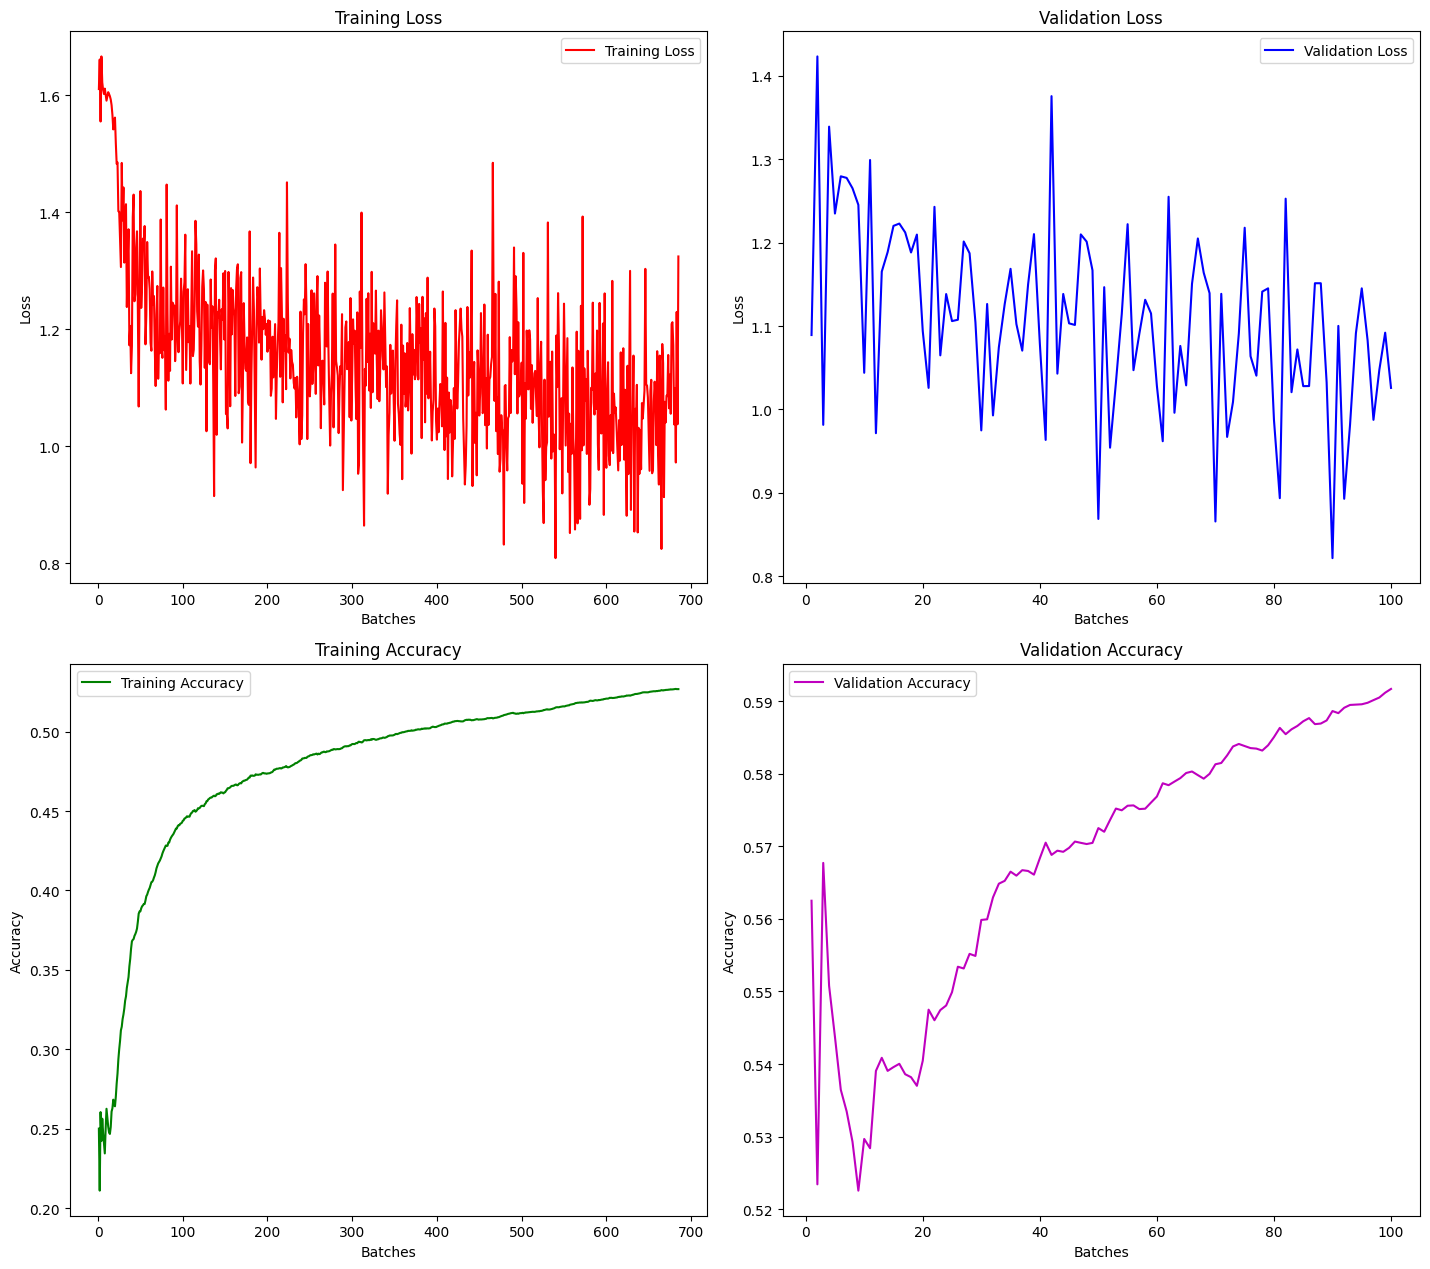

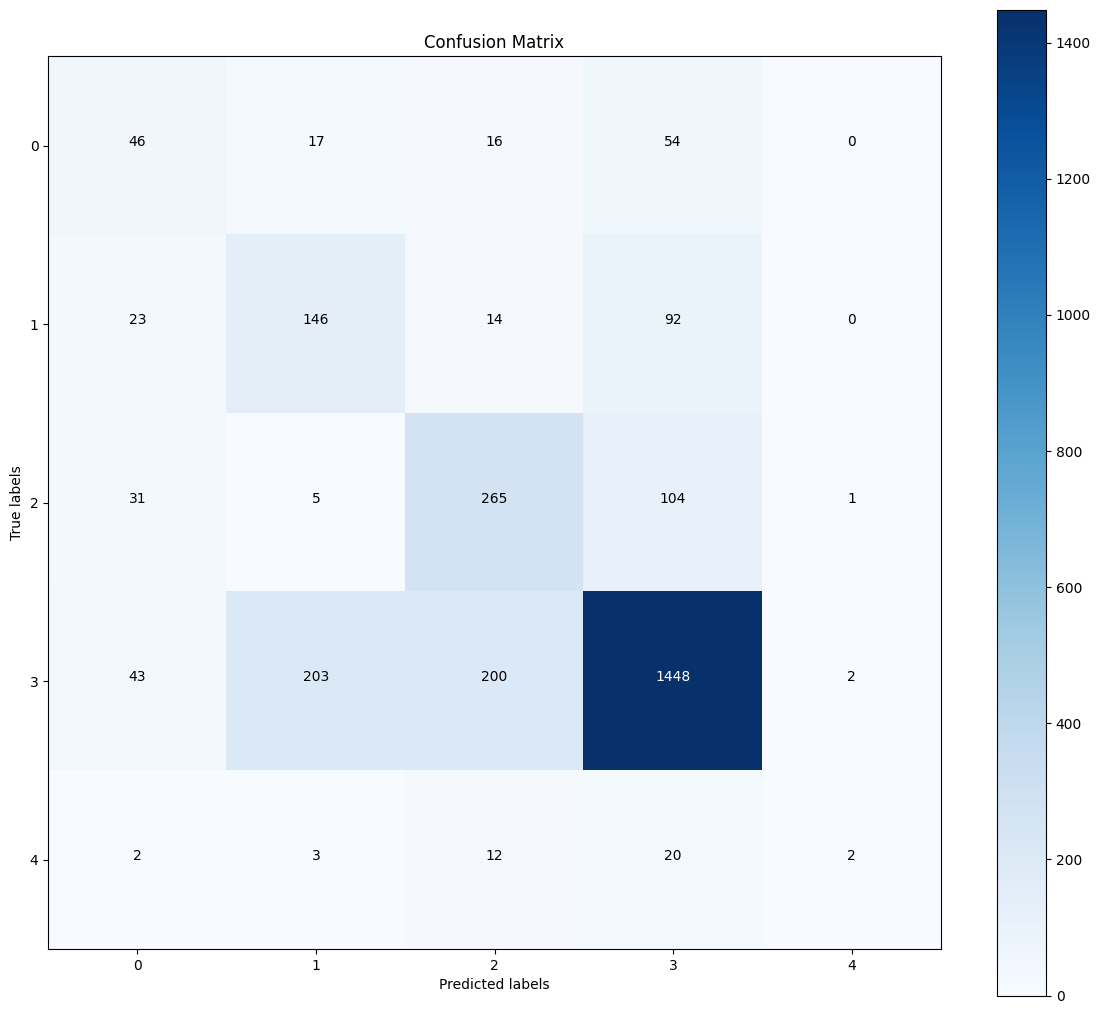

In [16]:
torch.manual_seed(42)

# Grid search values
number_epochs = [5]
batch_sizes = [64]
learning_rates = [0.001]

print("Models to train: ", len(number_epochs) * len(batch_sizes) * len(learning_rates))

# Track the model number for each combination of hyperparameters
model_number = 0

# For each combination of hyperparameters train and test the model
for epochs in number_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            
            # Print the current model number and hyperparameters
            print()
            print("Training model number: ", model_number)
            print("Epochs: ", epochs, " Batch size: ", batch_size, " Learning rate: ", learning_rate)
            print()
            
            # Create the model and the optimizer
            simple_model = SimpleCNN()
            optimizer = torch.optim.Adam(simple_model.parameters(), lr=learning_rate)

            # Load the data            
            train_loader, validation_loader, test_loader = load_data(augmented_dataset, test_dataset, batch_size)
            
            # Train and test the model
            loss_history, accuracy_history, validation_loss_history, validation_accuracy_history = train_model(simple_model, train_loader, validation_loader, num_epochs=epochs, optimizer=optimizer)
            test_accuracy, test_precision, test_recall, test_f1, confusion_matrix = test_model(simple_model, test_loader)
            
            # Plot the metrics
            plot_metrics(loss_history, validation_loss_history, accuracy_history, validation_accuracy_history, confusion_matrix)
            
            # Update the model number
            model_number += 1


Let's train the AdvancedCNN model making a grid search to find the best hyperparameters.

Models to train:  8

Training model number:  1
Epochs:  1  Batch size:  64  Learning rate:  0.01

Training...
Batch number:  16 / 80
Current loss:  1.543603777885437
Elapsed time:  0.2748830318450928
Estimated time:  17.592514038085938
Batch number:  32 / 80
Current loss:  1.566193699836731
Elapsed time:  0.2710440158843994
Estimated time:  13.010112762451172
Batch number:  48 / 80
Current loss:  1.508668065071106
Elapsed time:  0.3537173271179199
Estimated time:  11.318954467773438
Batch number:  64 / 80
Current loss:  1.481764554977417
Elapsed time:  0.2713475227355957
Estimated time:  4.341560363769531
Batch number:  80 / 80
Current loss:  1.5109460353851318
Elapsed time:  0.17003870010375977
Estimated time:  0.0
Epoch 1, Training Loss: 1.5109460353851318, Validation Loss: 1.5003432035446167
Epoch 1, Training Accuracy: 0.29925432801246643, Validation Accuracy: 0.31814610958099365
Testing...
Batch number:  16 / 43
Batch number:  32 / 43
Accuracy: 68.97053718566895%
Precision: 47.5693

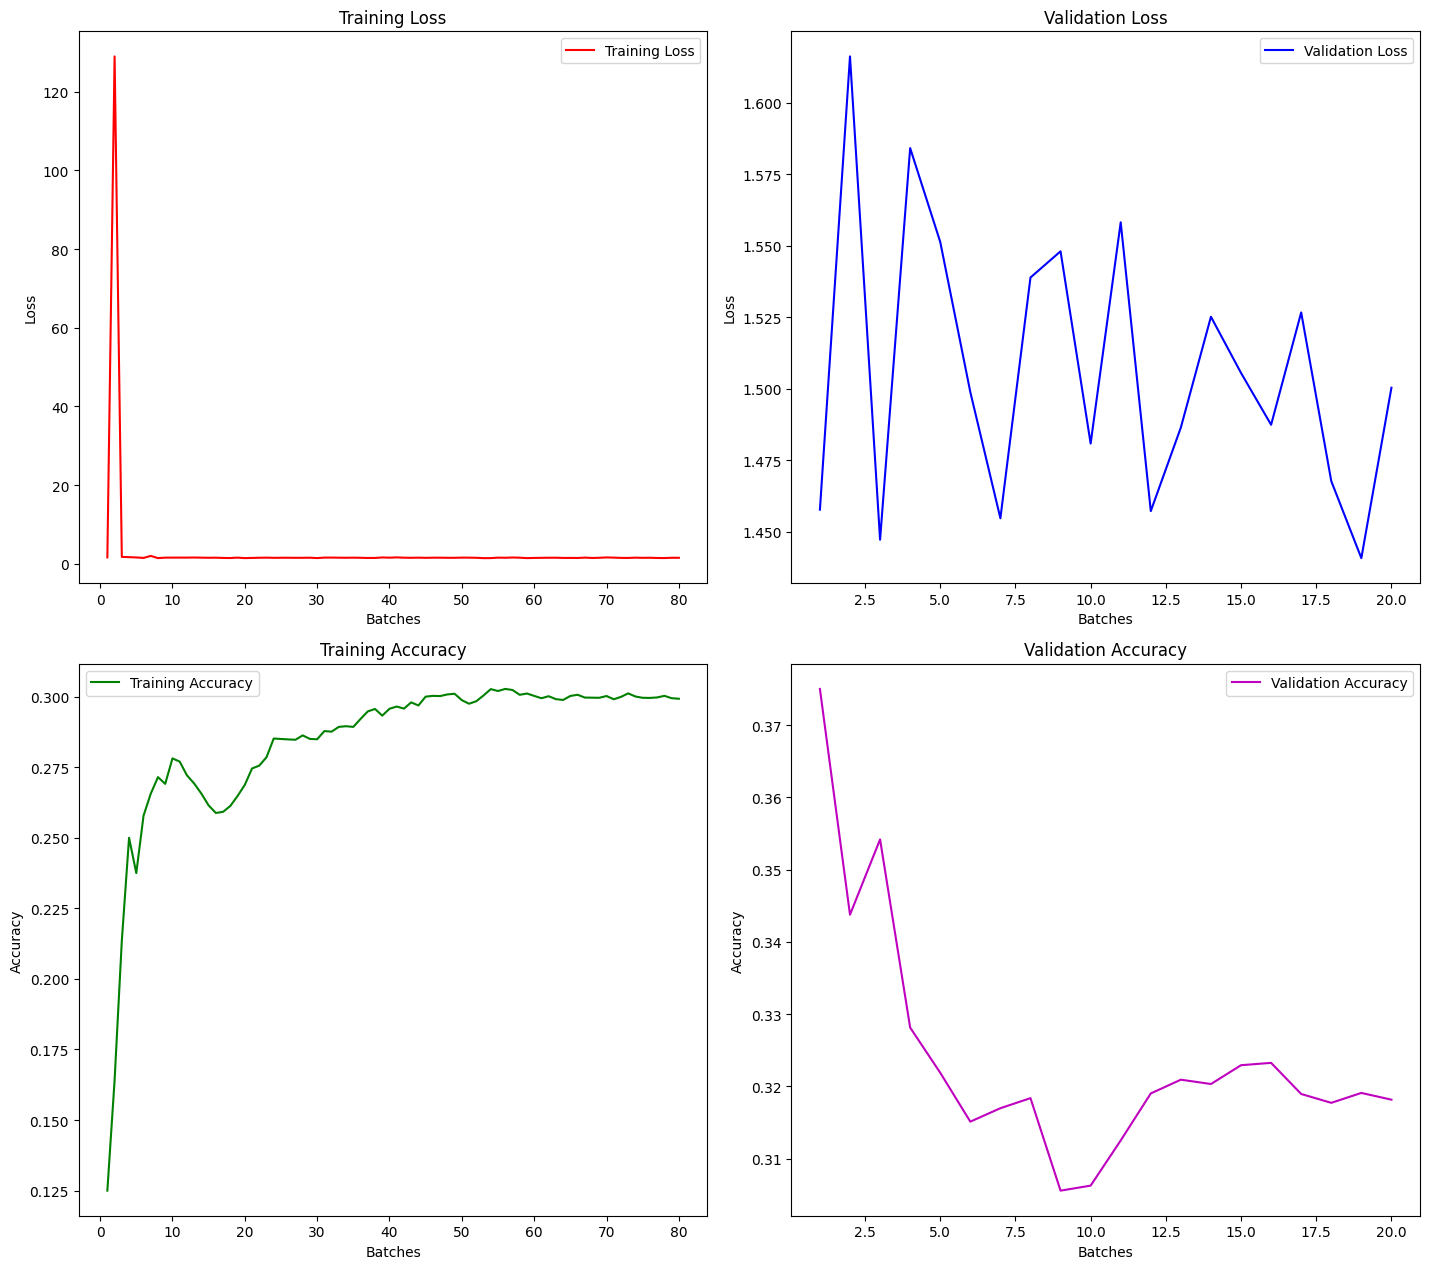

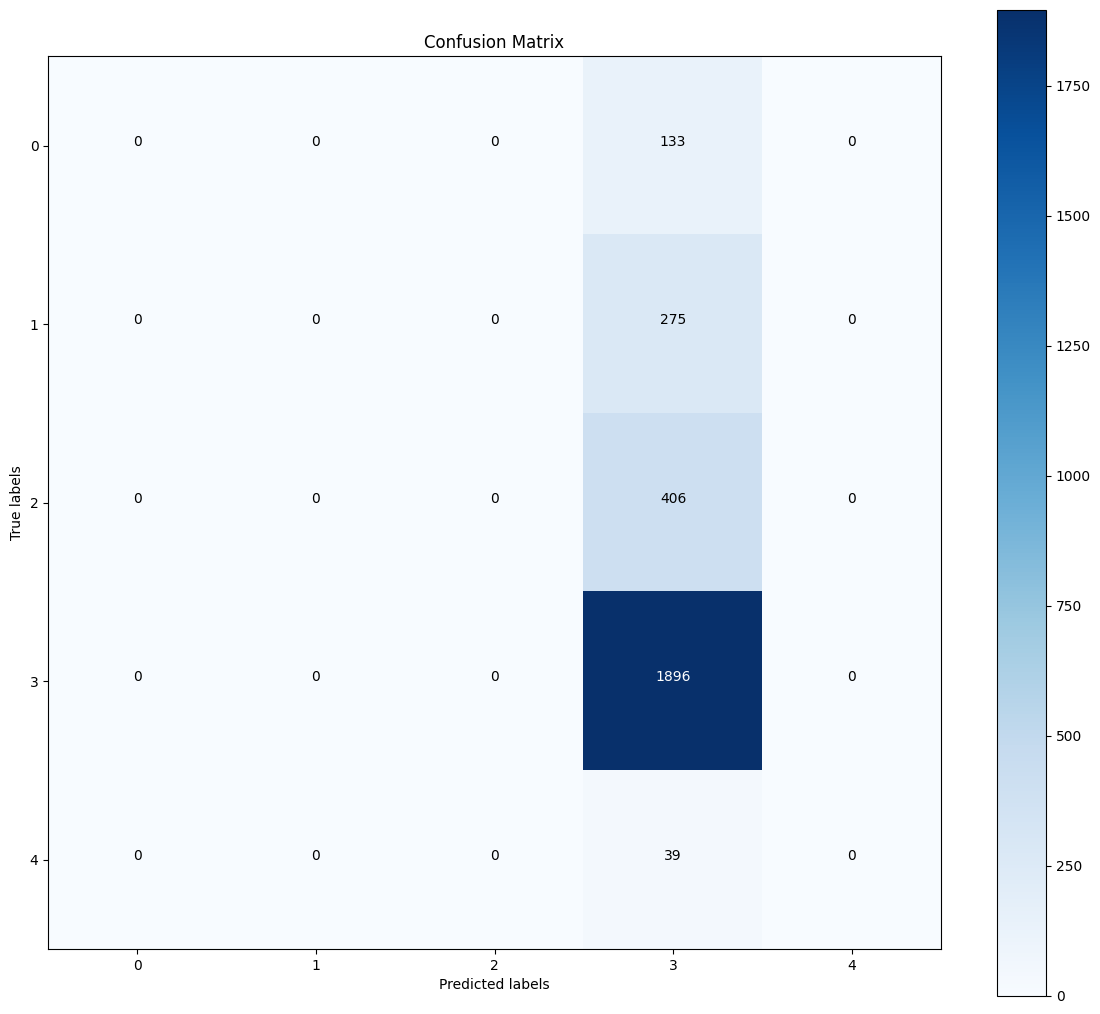


Training model number:  2
Epochs:  1  Batch size:  64  Learning rate:  0.001

Training...
Batch number:  16 / 80
Current loss:  1.5280994176864624
Elapsed time:  0.27694034576416016
Estimated time:  17.72418212890625
Batch number:  32 / 80
Current loss:  1.5088392496109009
Elapsed time:  0.27805209159851074
Estimated time:  13.346500396728516
Batch number:  48 / 80
Current loss:  1.3902701139450073
Elapsed time:  0.2993450164794922
Estimated time:  9.57904052734375
Batch number:  64 / 80
Current loss:  1.2881073951721191
Elapsed time:  0.27636027336120605
Estimated time:  4.421764373779297
Batch number:  80 / 80
Current loss:  1.3334968090057373
Elapsed time:  0.18529844284057617
Estimated time:  0.0
Epoch 1, Training Loss: 1.3334968090057373, Validation Loss: 1.1173081398010254
Epoch 1, Training Accuracy: 0.3901098966598511, Validation Accuracy: 0.5200313925743103
Testing...
Batch number:  16 / 43
Batch number:  32 / 43
Accuracy: 57.80283808708191%
Precision: 66.31540656089783%
Recal

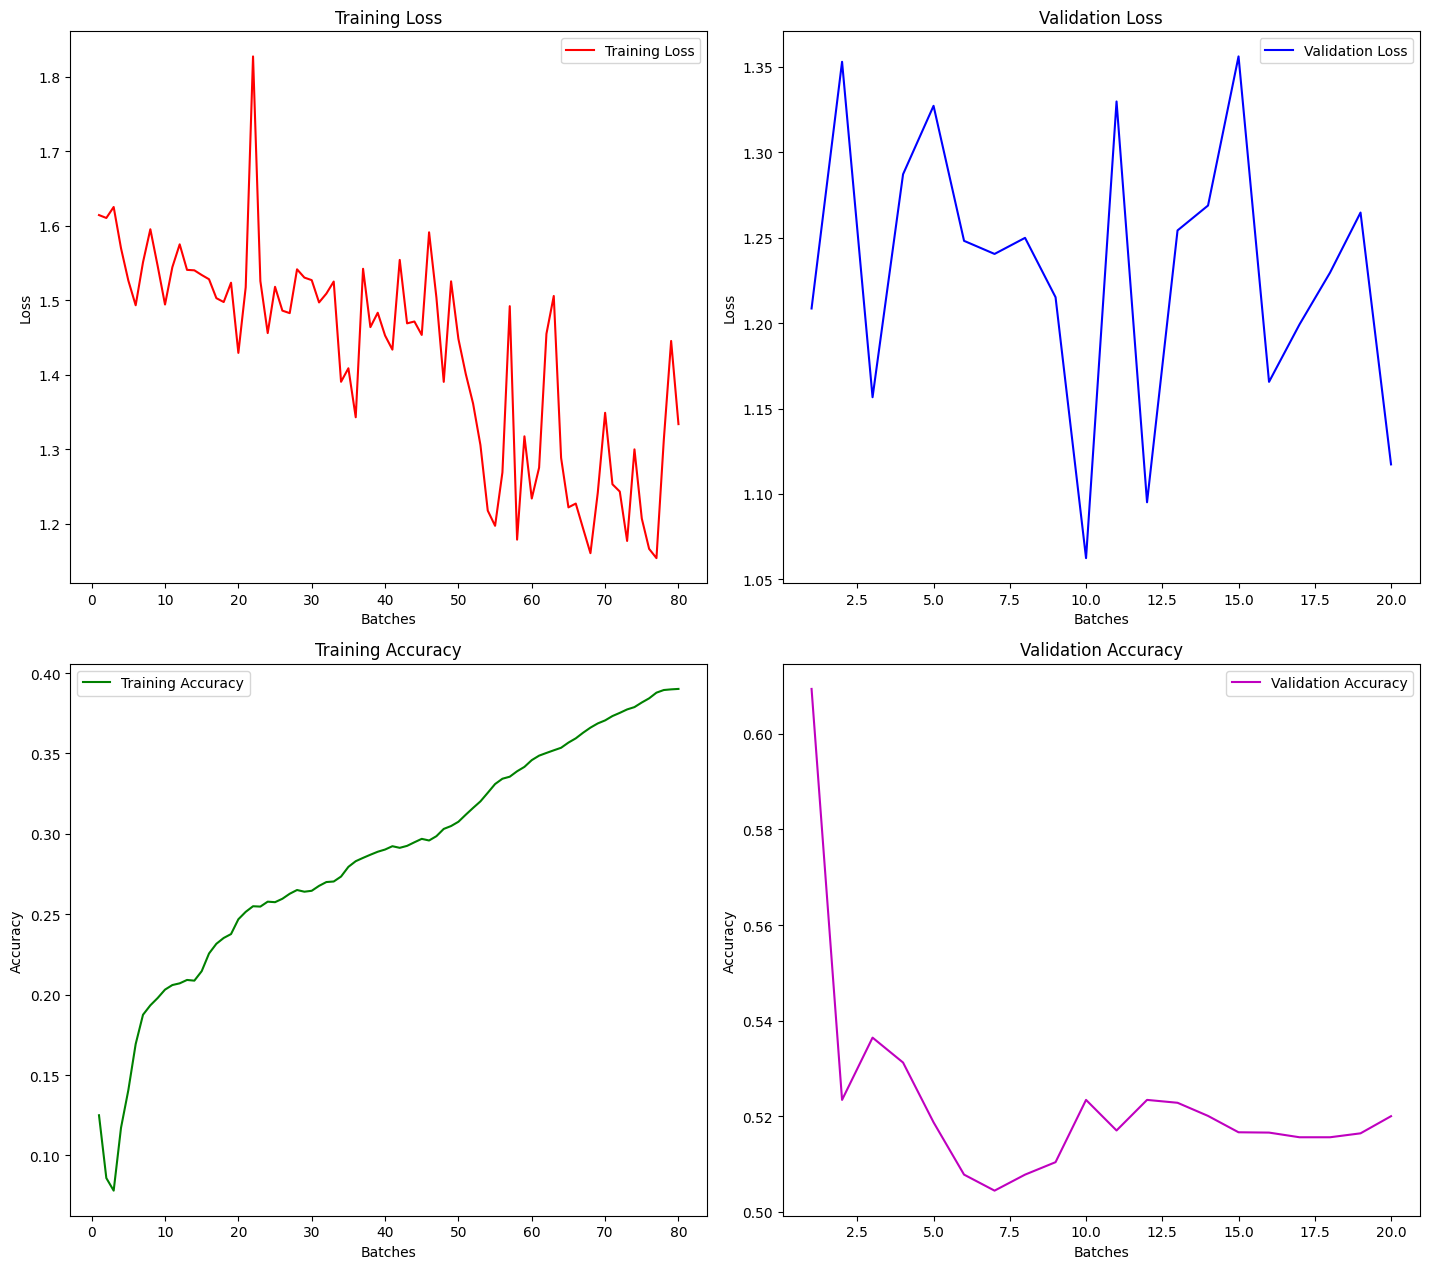

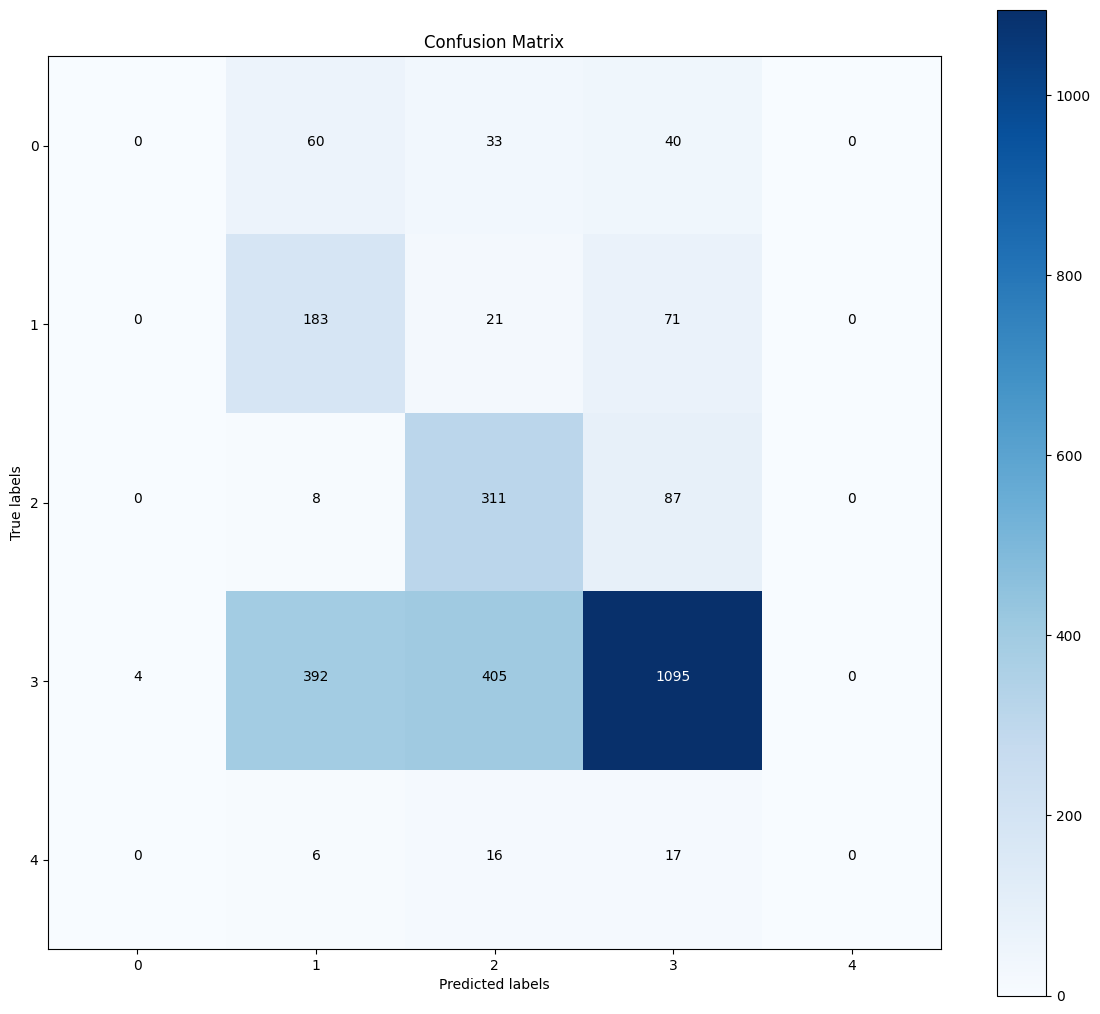


Training model number:  3
Epochs:  3  Batch size:  64  Learning rate:  0.01

Training...
Batch number:  16 / 240
Current loss:  1.5666489601135254
Elapsed time:  0.2719745635986328
Estimated time:  60.92230224609375
Batch number:  32 / 240
Current loss:  1.5088024139404297
Elapsed time:  0.2729220390319824
Estimated time:  56.767784118652344
Batch number:  48 / 240
Current loss:  1.4804449081420898
Elapsed time:  0.27124691009521484
Estimated time:  52.07940673828125
Batch number:  64 / 240
Current loss:  1.5971362590789795
Elapsed time:  0.271740198135376
Estimated time:  47.82627487182617
Batch number:  80 / 240
Current loss:  1.4411689043045044
Elapsed time:  0.17924118041992188
Estimated time:  28.6785888671875
Epoch 1, Training Loss: 1.4411689043045044, Validation Loss: 1.5482925176620483
Epoch 1, Training Accuracy: 0.2845368981361389, Validation Accuracy: 0.31814610958099365
Batch number:  96 / 240
Current loss:  1.5124502182006836
Elapsed time:  0.2854635715484619
Estimated tim

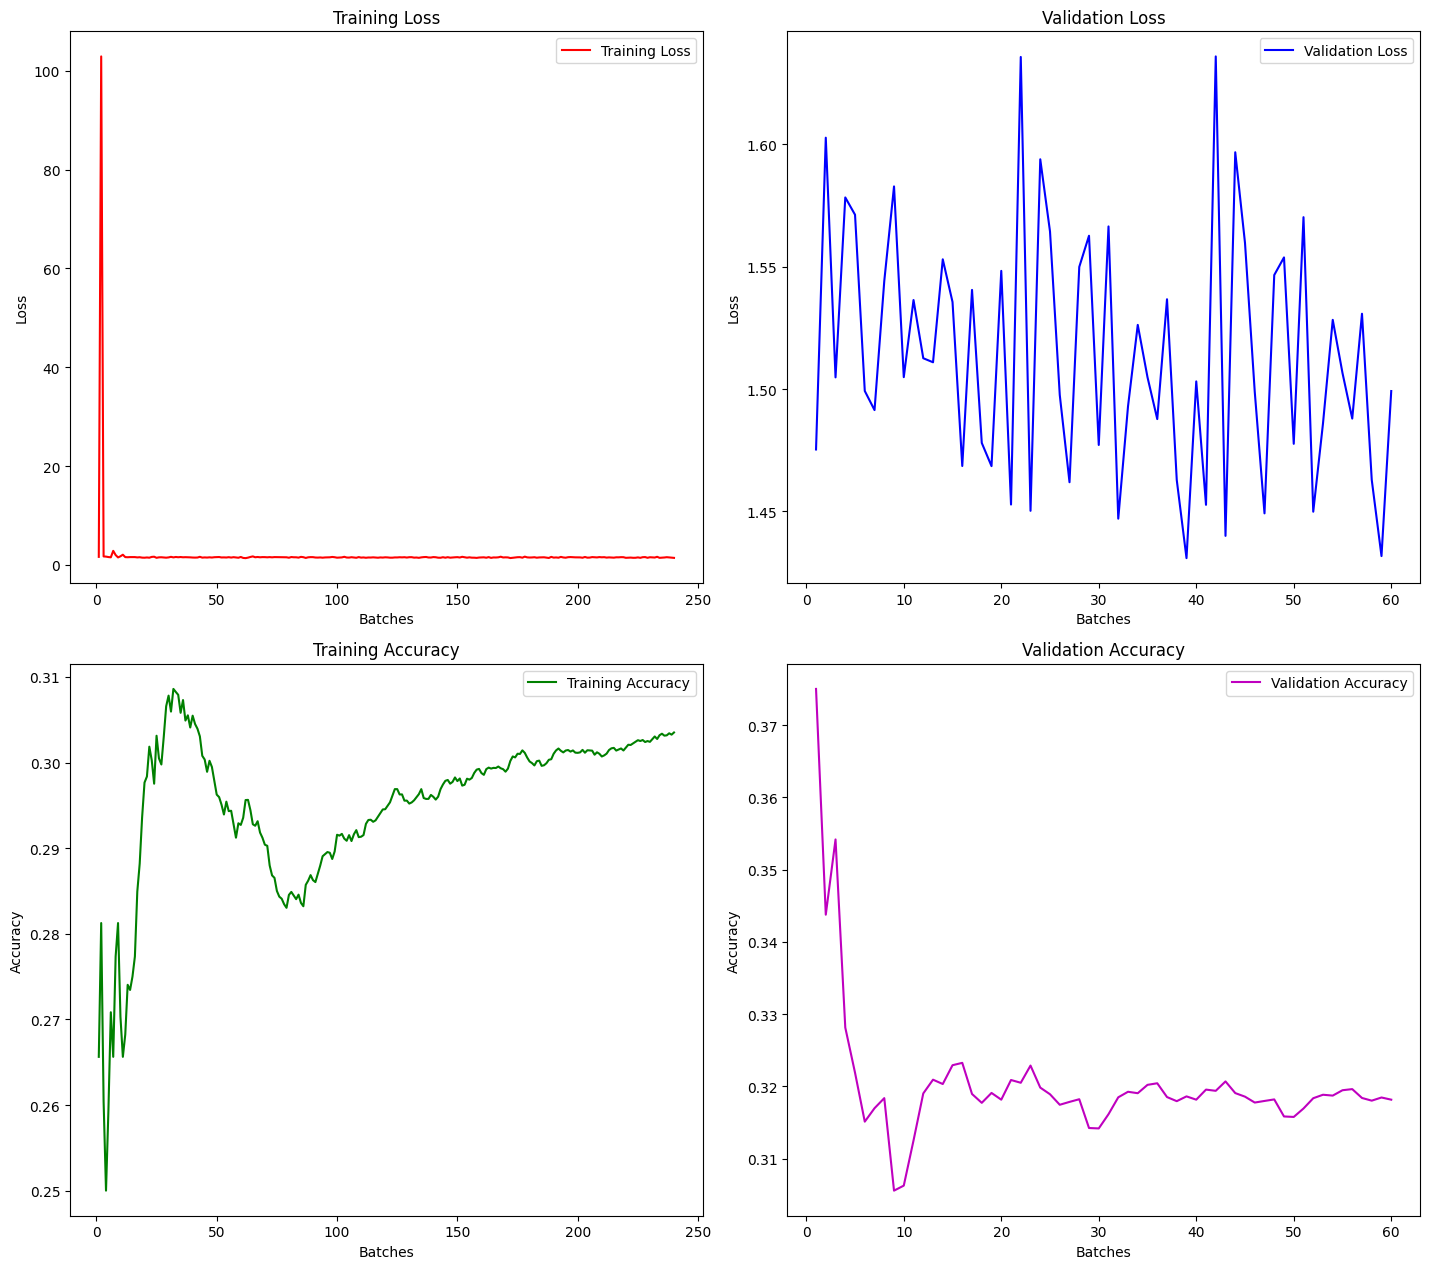

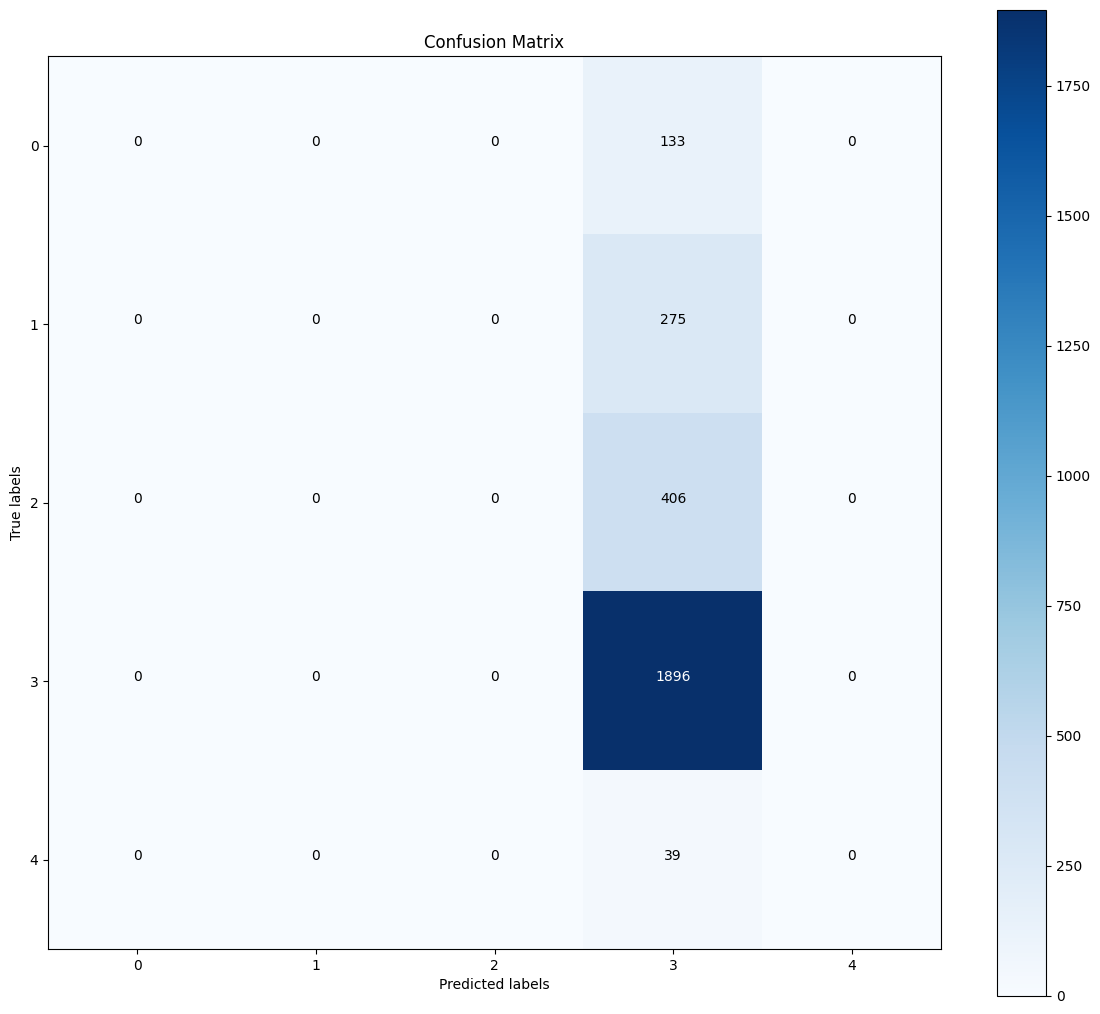


Training model number:  4
Epochs:  3  Batch size:  64  Learning rate:  0.001

Training...
Batch number:  16 / 240
Current loss:  1.4740092754364014
Elapsed time:  0.299971342086792
Estimated time:  67.1935806274414
Batch number:  32 / 240
Current loss:  1.5563559532165527
Elapsed time:  0.47341084480285645
Estimated time:  98.46945571899414
Batch number:  48 / 240
Current loss:  1.2884771823883057
Elapsed time:  0.27611827850341797
Estimated time:  53.01470947265625
Batch number:  64 / 240
Current loss:  1.3065739870071411
Elapsed time:  0.277606725692749
Estimated time:  48.85878372192383
Batch number:  80 / 240
Current loss:  1.14402174949646
Elapsed time:  0.17956113815307617
Estimated time:  28.729782104492188
Epoch 1, Training Loss: 1.14402174949646, Validation Loss: 1.1300160884857178
Epoch 1, Training Accuracy: 0.41718995571136475, Validation Accuracy: 0.5153181552886963
Batch number:  96 / 240
Current loss:  1.1097962856292725
Elapsed time:  0.2727668285369873
Estimated time: 

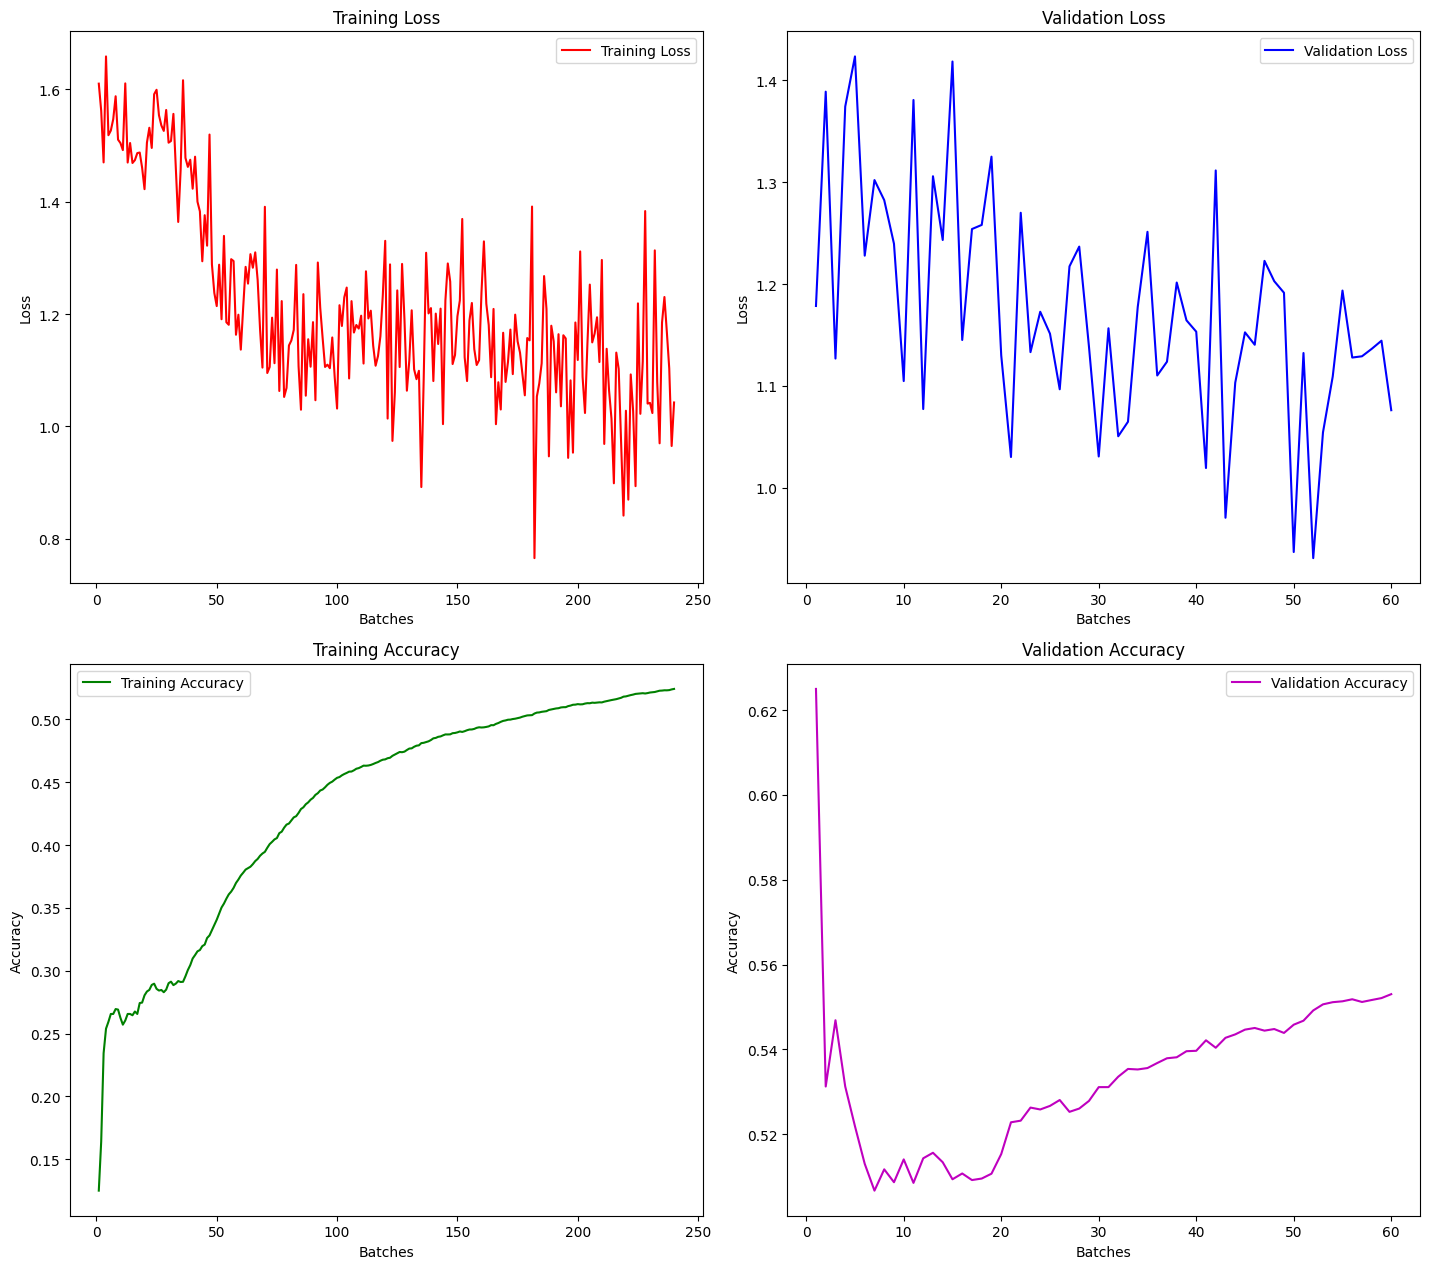

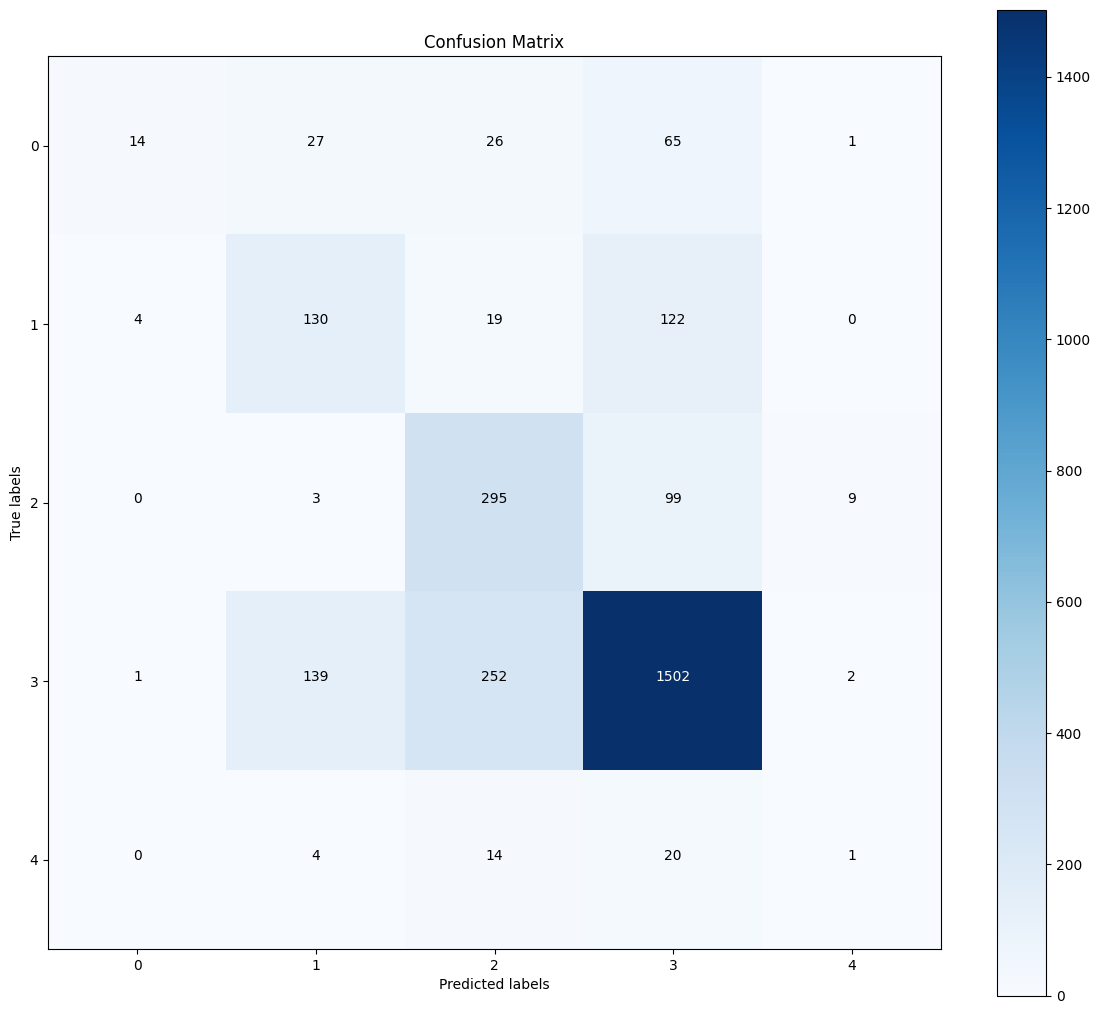


Training model number:  5
Epochs:  4  Batch size:  64  Learning rate:  0.01

Training...
Batch number:  16 / 320
Current loss:  1.505664587020874
Elapsed time:  0.29925036430358887
Estimated time:  90.97211074829102
Batch number:  32 / 320
Current loss:  1.4301146268844604
Elapsed time:  0.3495938777923584
Estimated time:  100.68303680419922
Batch number:  48 / 320
Current loss:  1.5358327627182007
Elapsed time:  0.26656651496887207
Estimated time:  72.5060920715332
Batch number:  64 / 320
Current loss:  1.444647192955017
Elapsed time:  0.2998182773590088
Estimated time:  76.75347900390625
Batch number:  80 / 320
Current loss:  1.5315773487091064
Elapsed time:  0.1709747314453125
Estimated time:  41.033935546875
Epoch 1, Training Loss: 1.5315773487091064, Validation Loss: 1.5077664852142334
Epoch 1, Training Accuracy: 0.305533766746521, Validation Accuracy: 0.31814610958099365
Batch number:  96 / 320
Current loss:  1.5490856170654297
Elapsed time:  0.2663998603820801
Estimated time:  

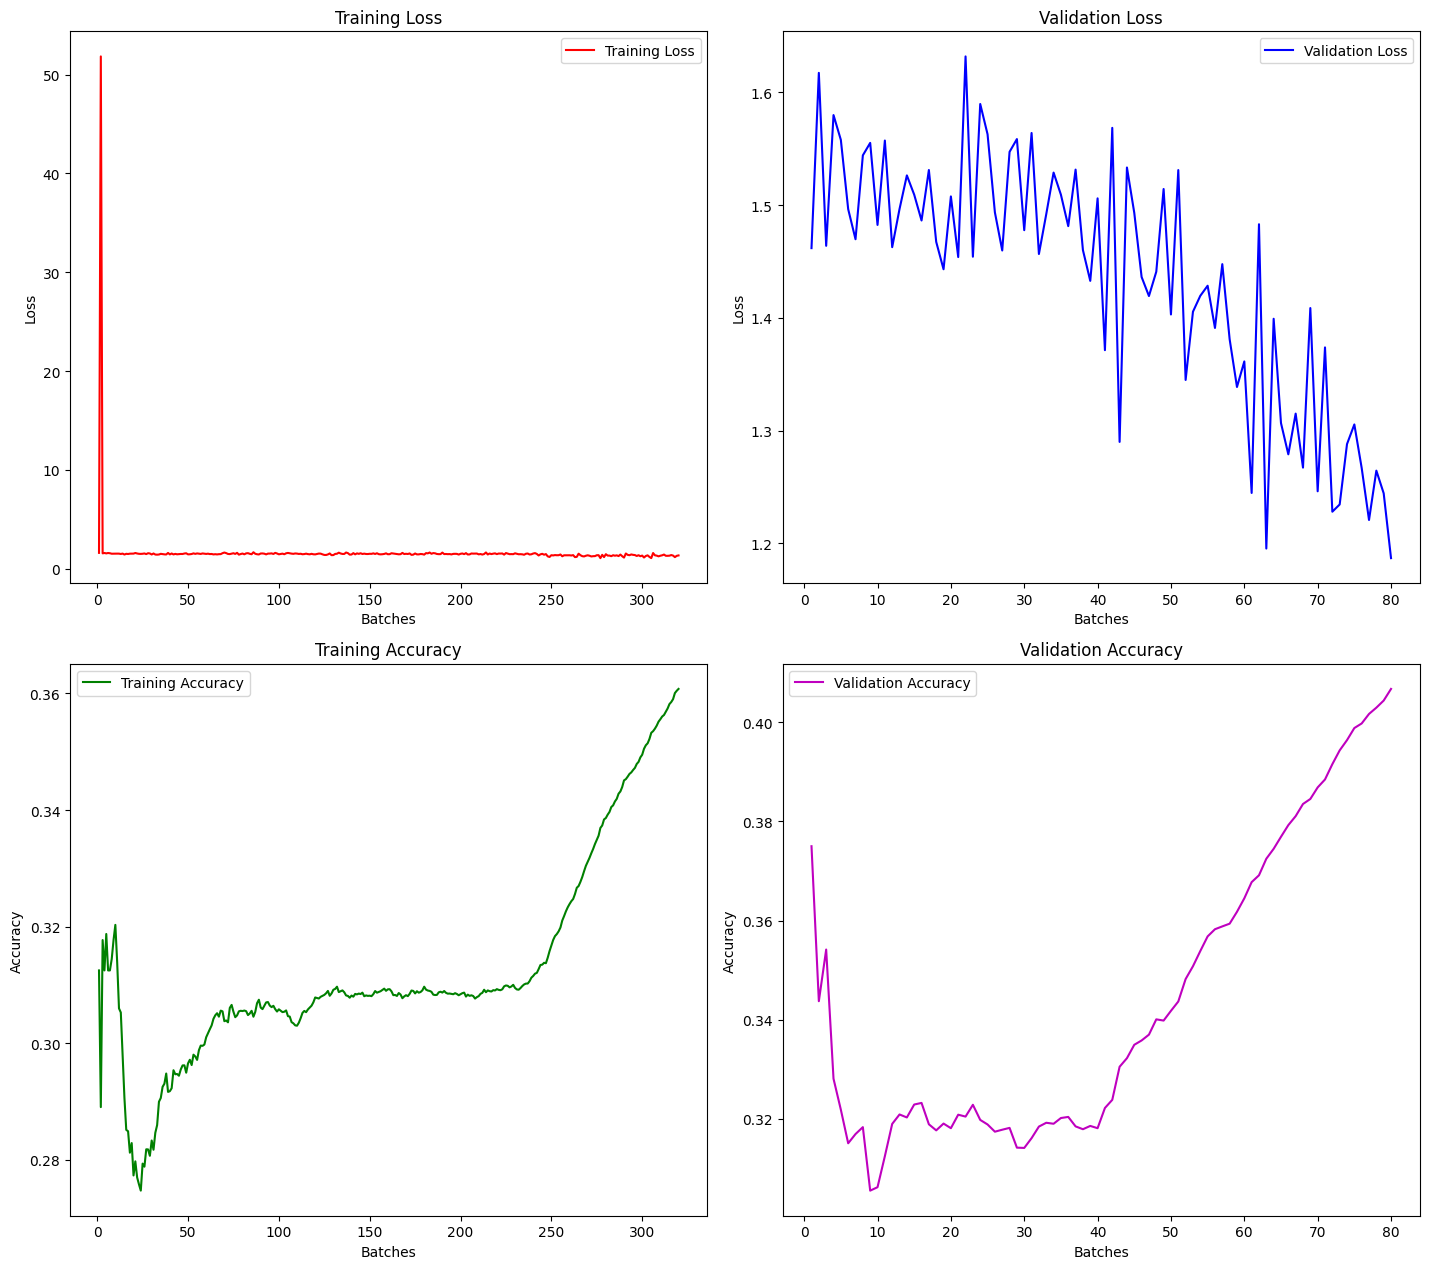

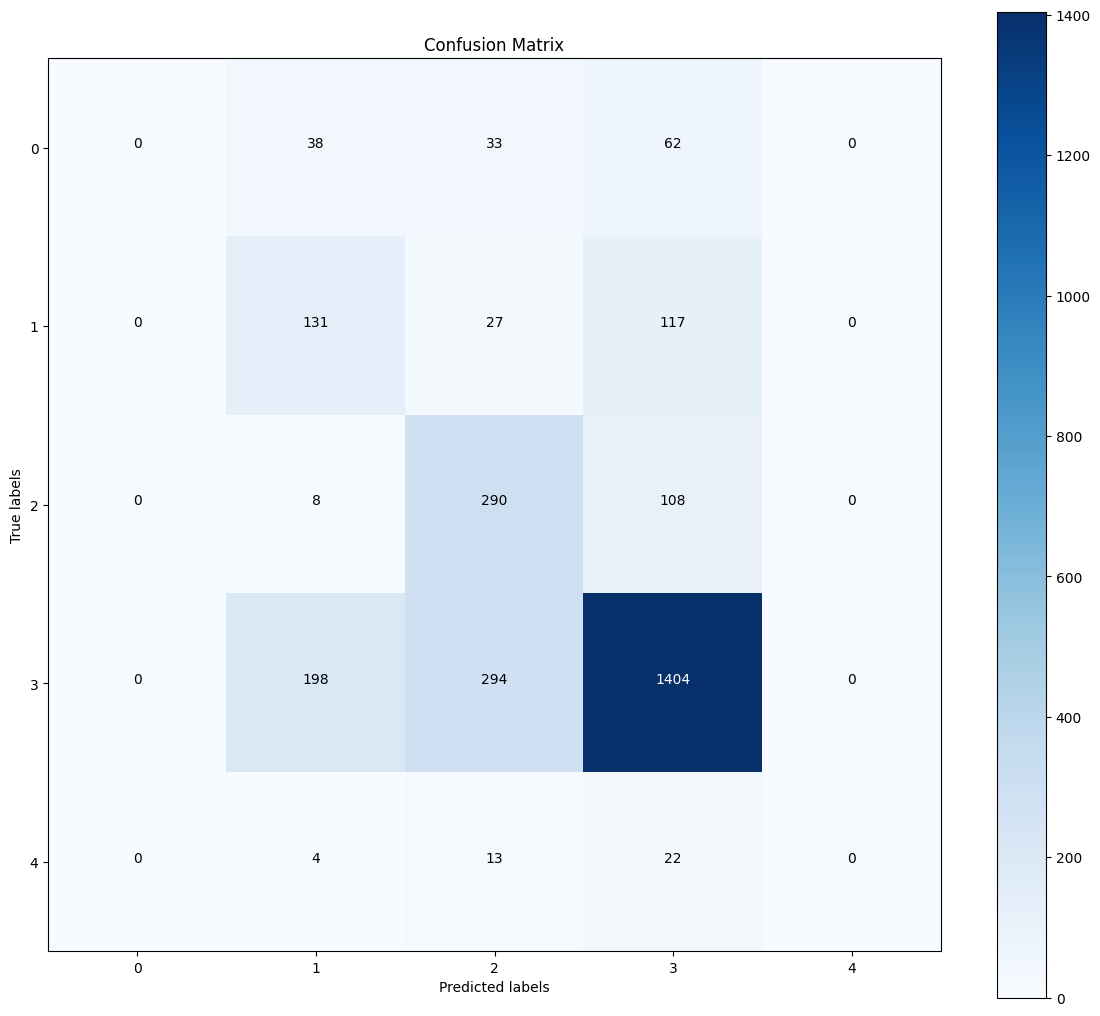


Training model number:  6
Epochs:  4  Batch size:  64  Learning rate:  0.001

Training...
Batch number:  16 / 320
Current loss:  1.455617070198059
Elapsed time:  0.2772996425628662
Estimated time:  84.29909133911133
Batch number:  32 / 320
Current loss:  1.5246878862380981
Elapsed time:  0.2853407859802246
Estimated time:  82.17814636230469
Batch number:  48 / 320
Current loss:  1.4344061613082886
Elapsed time:  0.27418088912963867
Estimated time:  74.57720184326172
Batch number:  64 / 320
Current loss:  1.2098546028137207
Elapsed time:  0.2737598419189453
Estimated time:  70.08251953125
Batch number:  80 / 320
Current loss:  1.2650175094604492
Elapsed time:  0.2157890796661377
Estimated time:  51.78937911987305
Epoch 1, Training Loss: 1.2650175094604492, Validation Loss: 1.1214715242385864
Epoch 1, Training Accuracy: 0.39521193504333496, Validation Accuracy: 0.5310290455818176
Batch number:  96 / 320
Current loss:  1.082401990890503
Elapsed time:  0.28237271308898926
Estimated time: 

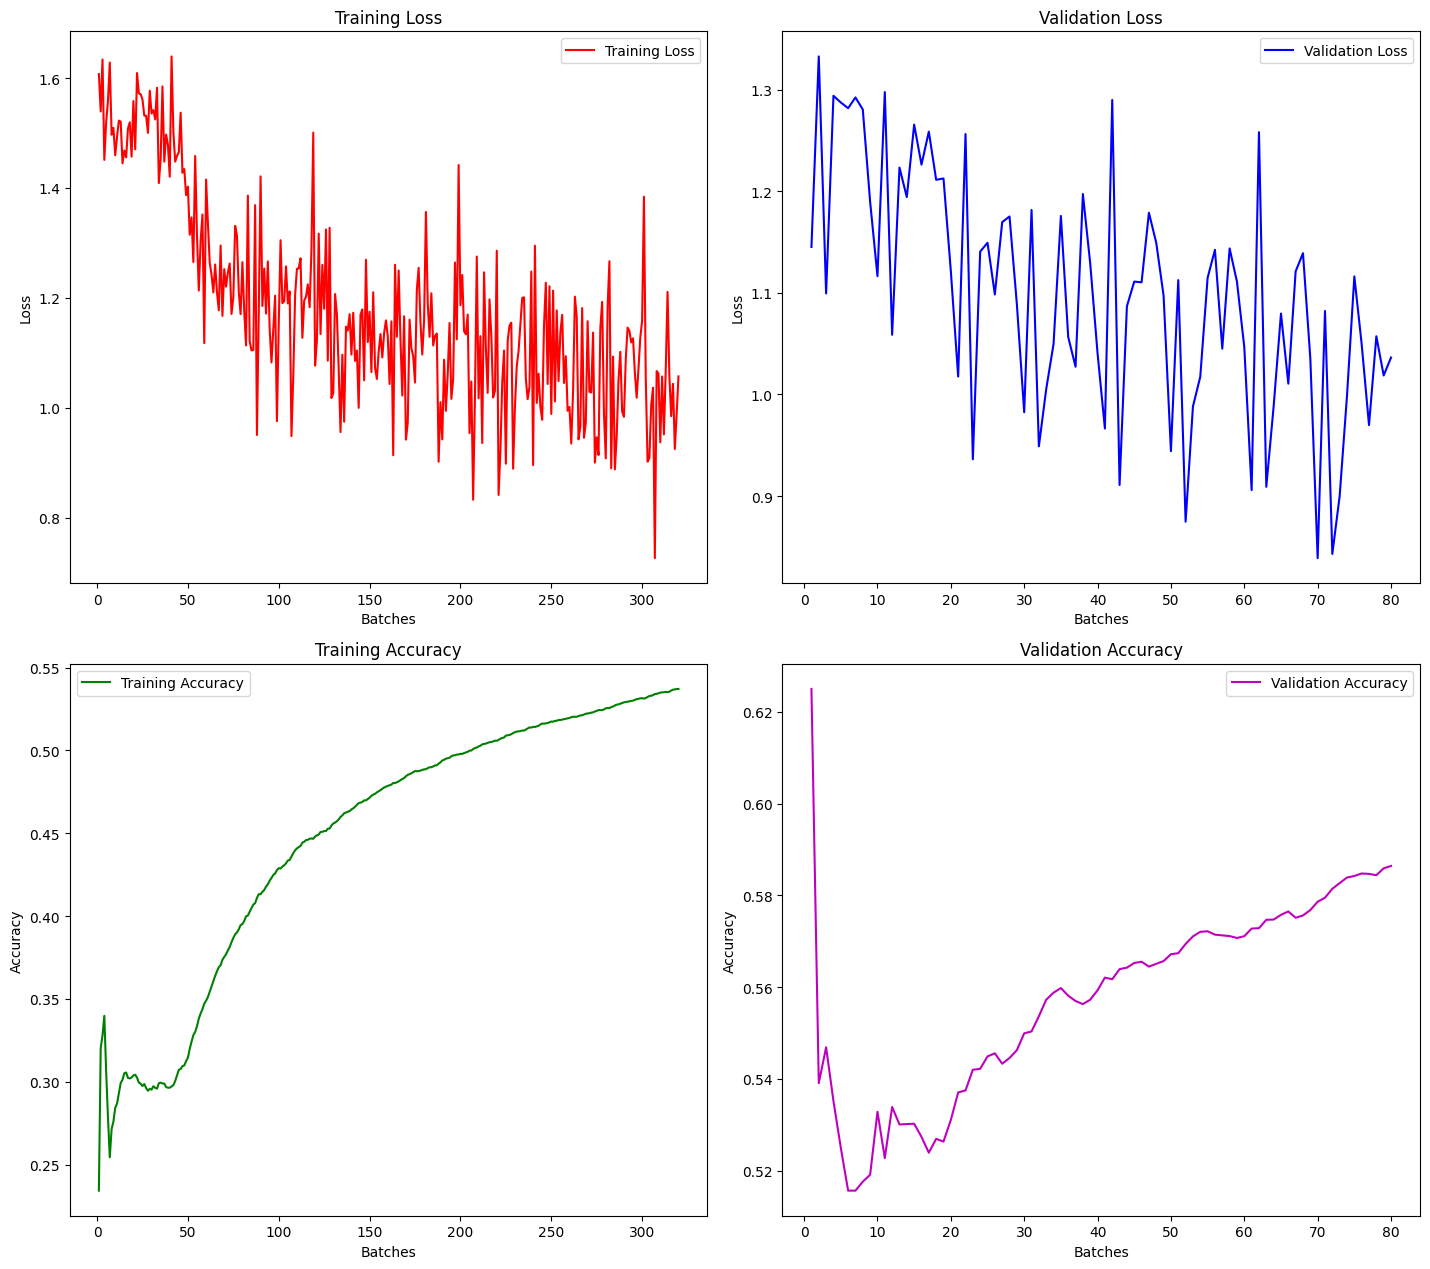

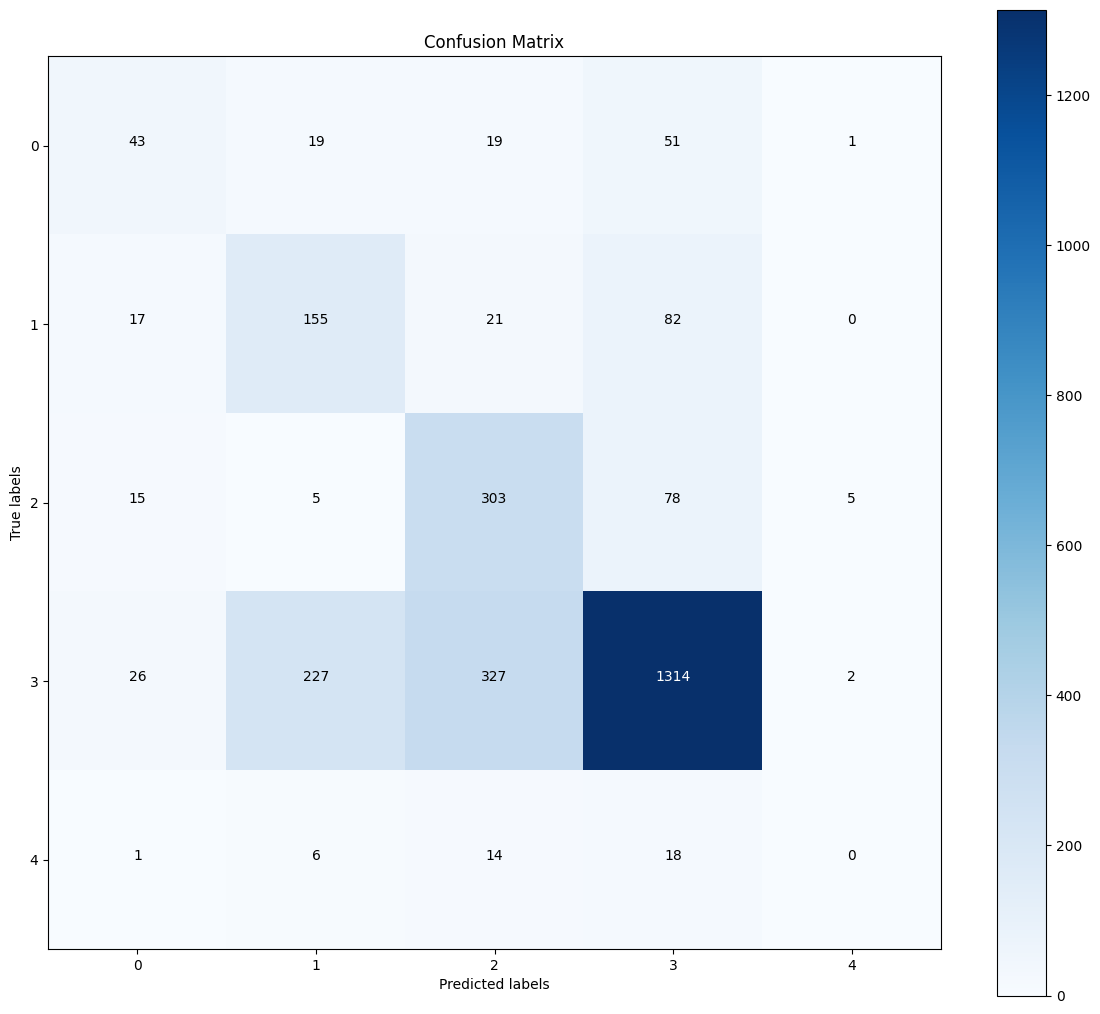


Training model number:  7
Epochs:  5  Batch size:  64  Learning rate:  0.01

Training...
Batch number:  16 / 400
Current loss:  1.4736570119857788
Elapsed time:  0.3235738277435303
Estimated time:  124.25234985351562
Batch number:  32 / 400
Current loss:  1.5304771661758423
Elapsed time:  0.2906367778778076
Estimated time:  106.9543342590332
Batch number:  48 / 400
Current loss:  1.5205779075622559
Elapsed time:  0.268216609954834
Estimated time:  94.41224670410156
Batch number:  64 / 400
Current loss:  1.4475607872009277
Elapsed time:  0.27239465713500977
Estimated time:  91.52460479736328
Batch number:  80 / 400
Current loss:  1.4941396713256836
Elapsed time:  0.16817903518676758
Estimated time:  53.817291259765625
Epoch 1, Training Loss: 1.4941396713256836, Validation Loss: 1.397013783454895
Epoch 1, Training Accuracy: 0.3074960708618164, Validation Accuracy: 0.42812255024909973
Batch number:  96 / 400
Current loss:  1.5972471237182617
Elapsed time:  0.30886197090148926
Estimated t

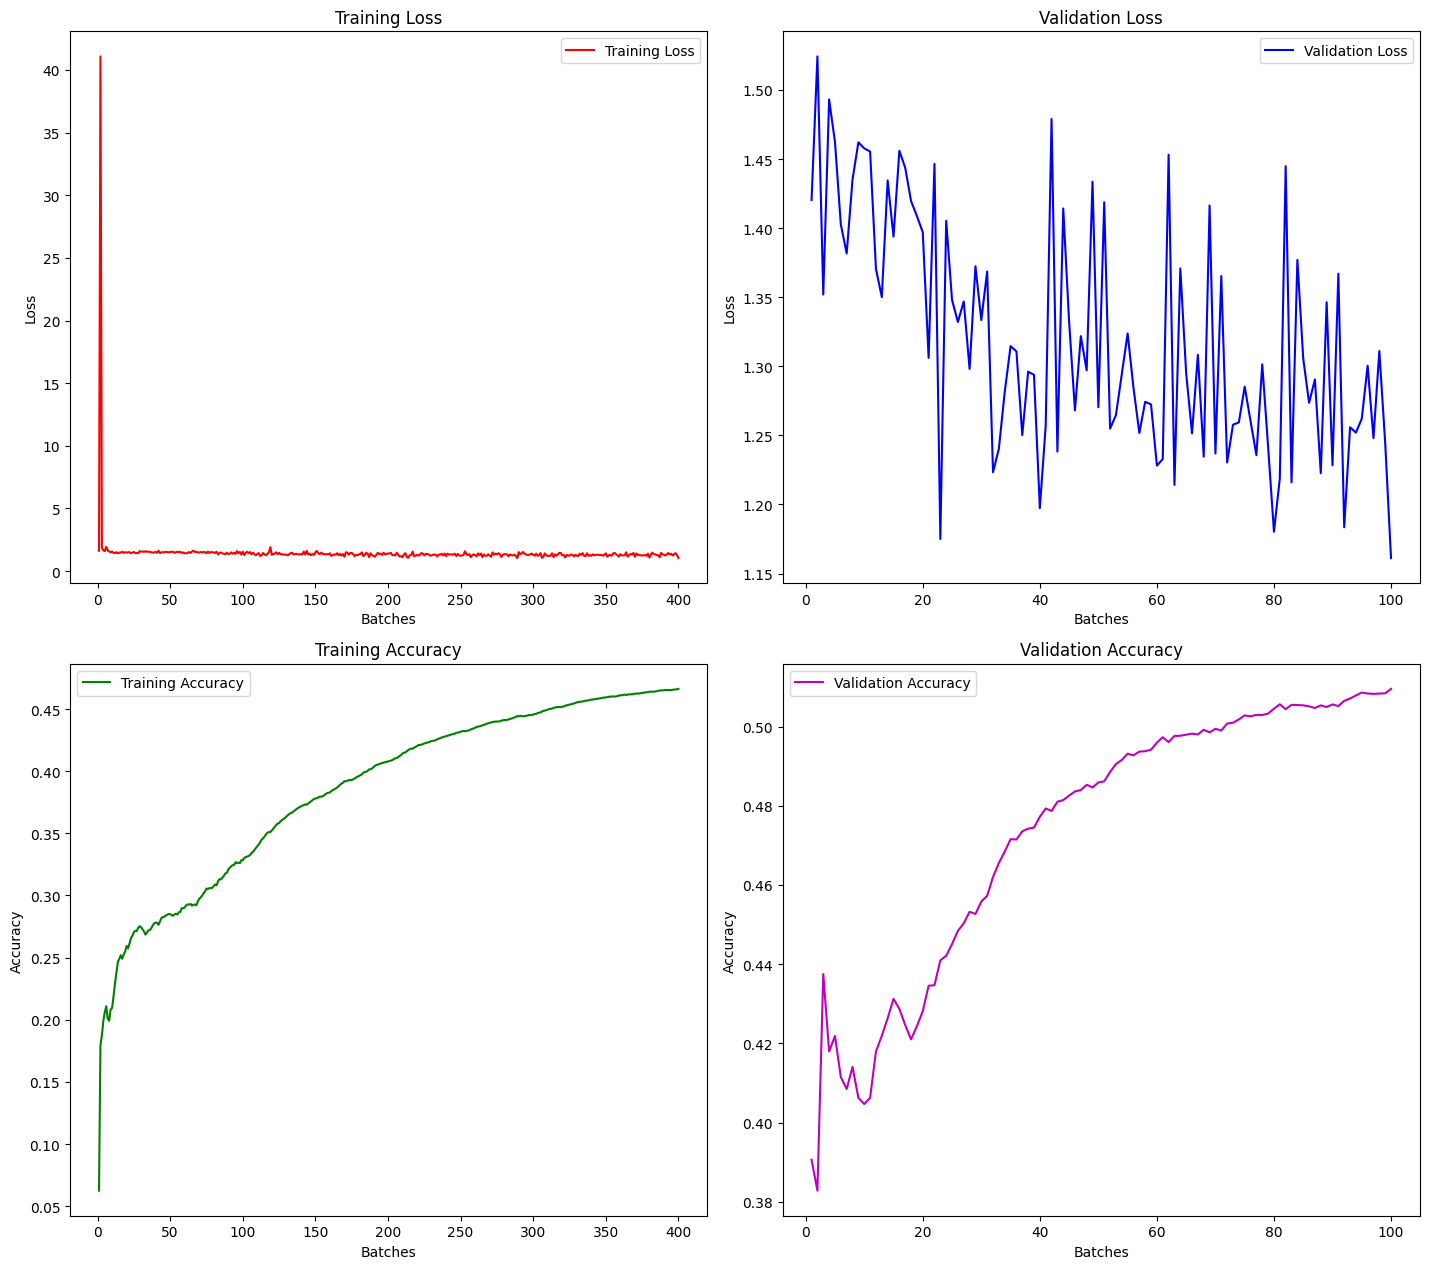

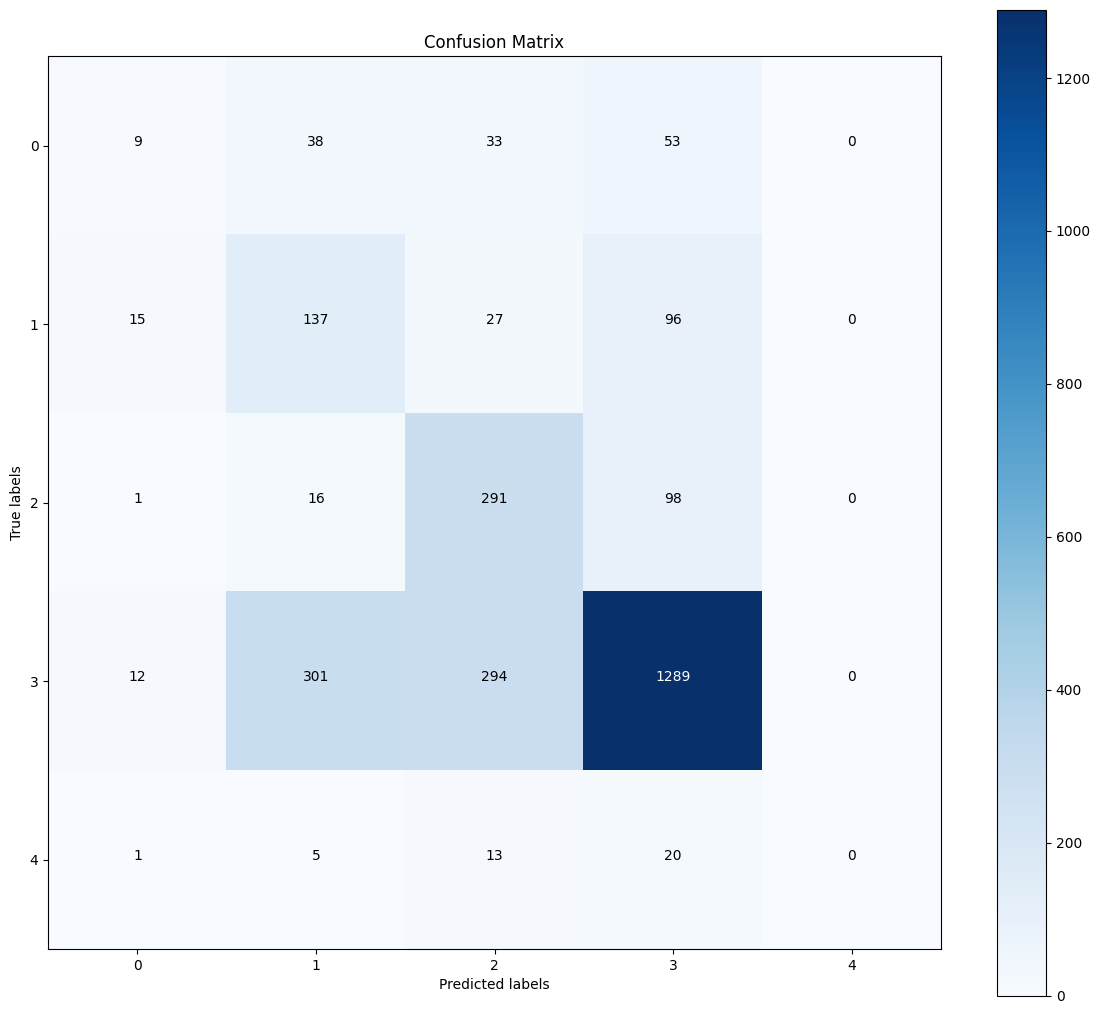


Training model number:  8
Epochs:  5  Batch size:  64  Learning rate:  0.001

Training...
Batch number:  16 / 400
Current loss:  1.5481412410736084
Elapsed time:  0.36307239532470703
Estimated time:  139.4197998046875
Batch number:  32 / 400
Current loss:  1.5378352403640747
Elapsed time:  0.2755734920501709
Estimated time:  101.41104507446289
Batch number:  48 / 400
Current loss:  1.4857426881790161
Elapsed time:  0.2952122688293457
Estimated time:  103.91471862792969
Batch number:  64 / 400
Current loss:  1.3544811010360718
Elapsed time:  0.2749593257904053
Estimated time:  92.38633346557617
Batch number:  80 / 400
Current loss:  1.264017105102539
Elapsed time:  0.17290782928466797
Estimated time:  55.33050537109375
Epoch 1, Training Loss: 1.264017105102539, Validation Loss: 1.1107096672058105
Epoch 1, Training Accuracy: 0.36872056126594543, Validation Accuracy: 0.5530243515968323
Batch number:  96 / 400
Current loss:  0.9895413517951965
Elapsed time:  0.30285024642944336
Estimated 

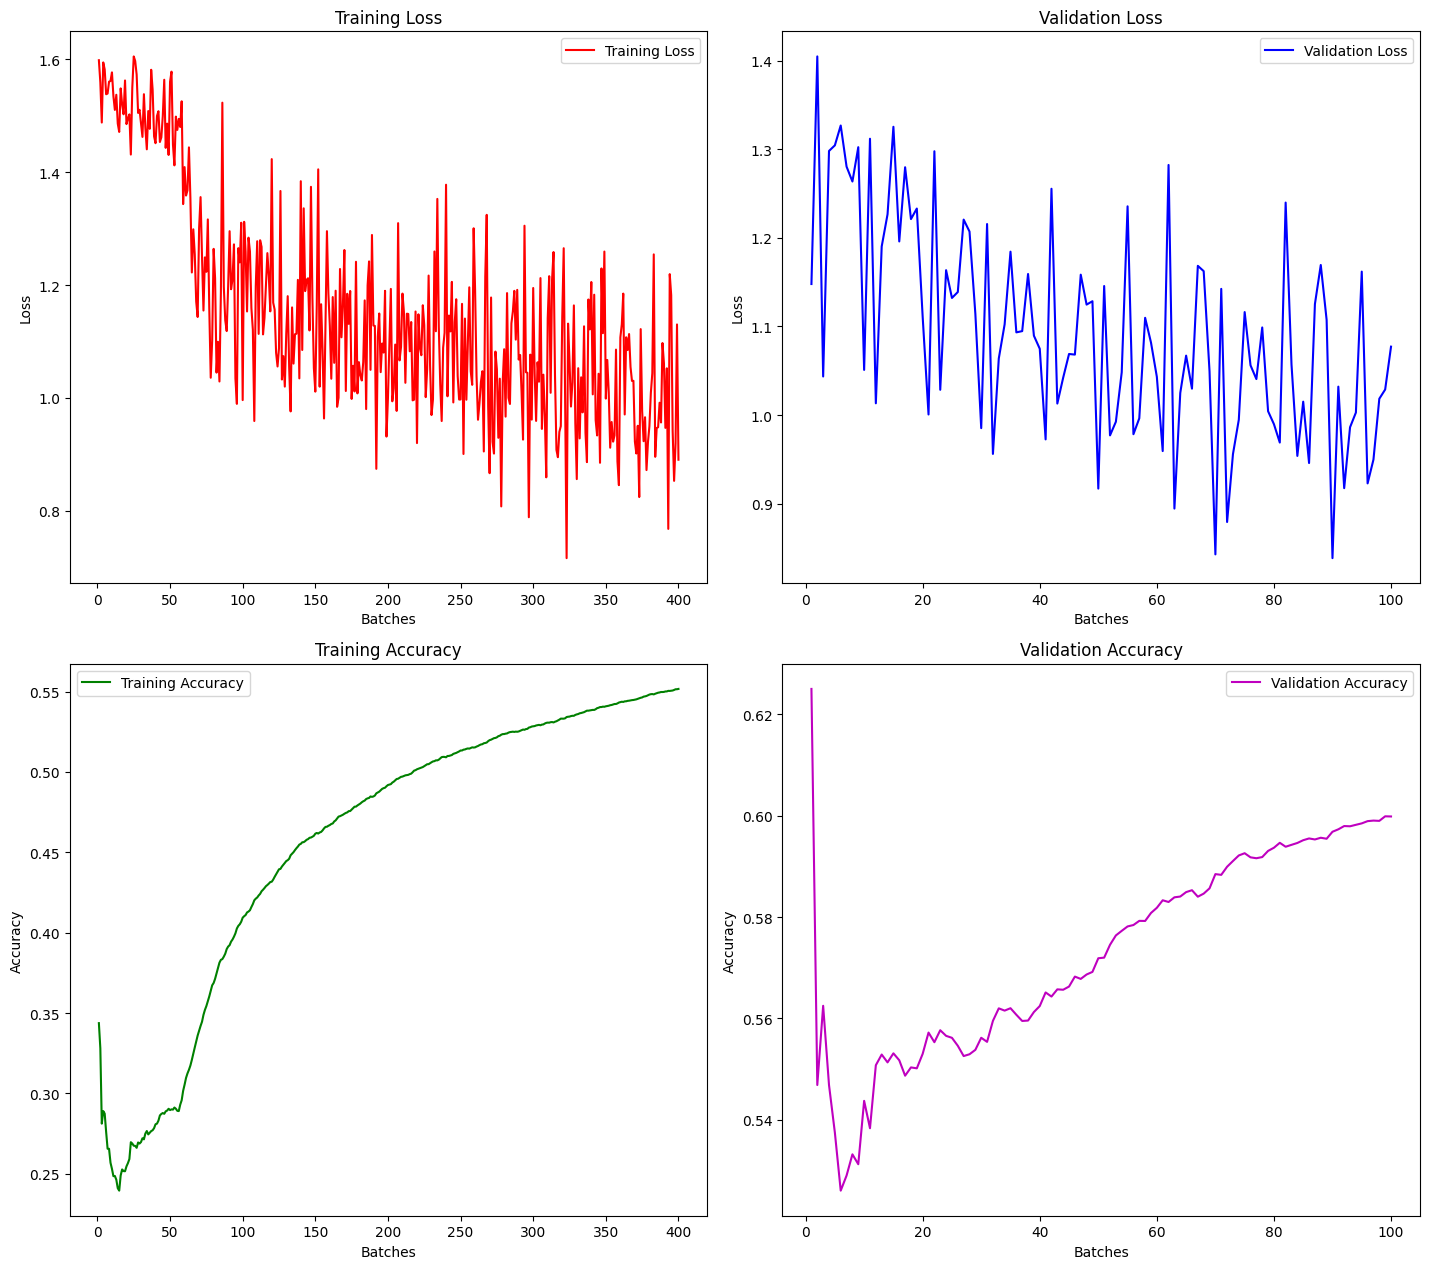

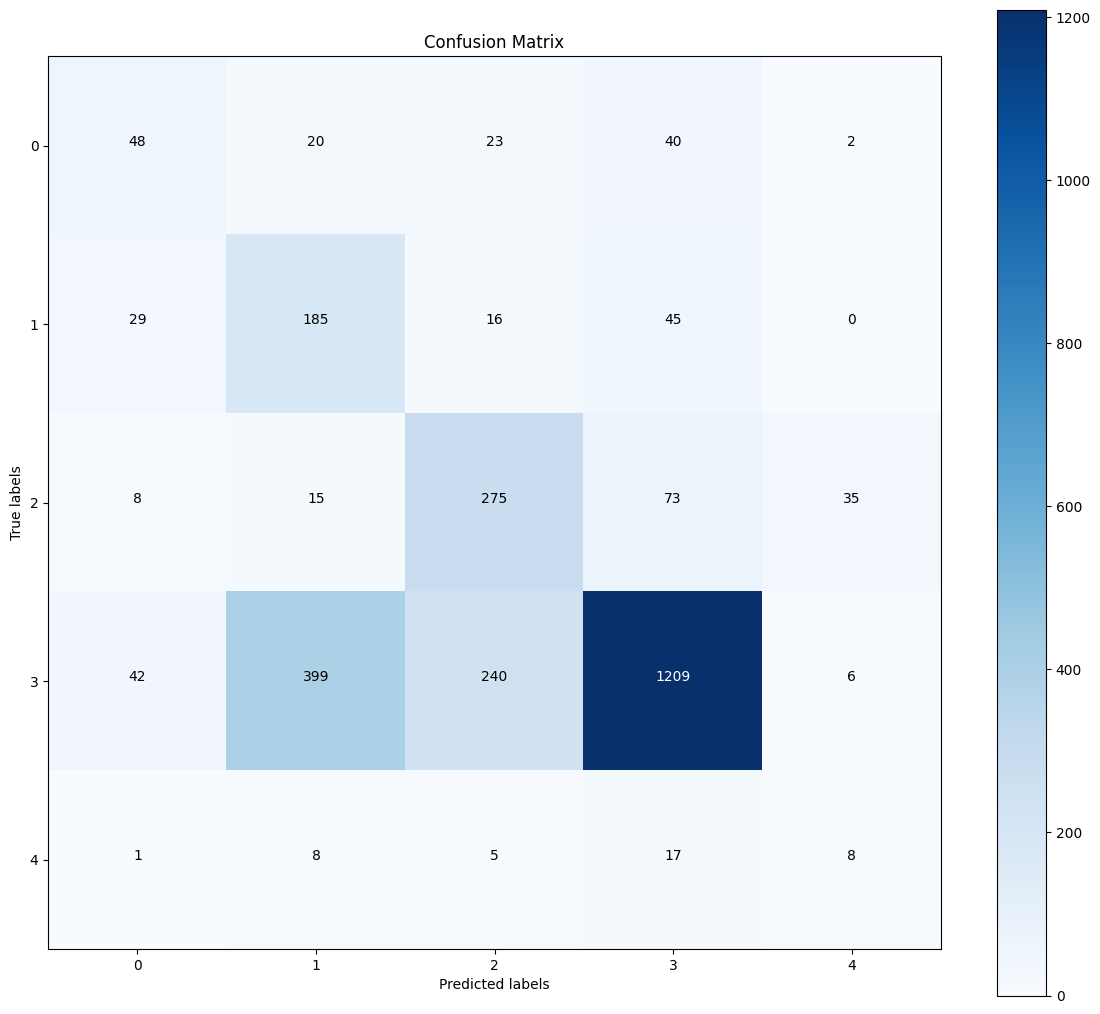

In [61]:
number_epochs = [1,3,4,5]
batch_sizes = [32, 64]
learning_rates = [0.01, 0.001]

print("Models to train: ", len(number_epochs) * len(batch_sizes) * len(learning_rates))

model_number = 1

for epochs in number_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            
            print()
            print("Training model number: ", model_number)
            print("Epochs: ", epochs, " Batch size: ", batch_size, " Learning rate: ", learning_rate)
            print()
            
            advanced_model = AdvancedCNN()
            optimizer = torch.optim.Adam(advanced_model.parameters(), lr=learning_rate)
            
            train_loader, validation_loader, test_loader = load_data(train_dataset, test_dataset, batch_size)
            
            loss_history, accuracy_history, validation_loss_history, validation_accuracy_history = train_model(advanced_model, train_loader, validation_loader, num_epochs=epochs, optimizer=optimizer)
            test_accuracy, test_precision, test_recall, test_f1, confusion_matrix = test_model(advanced_model, test_loader)
            
            plot_metrics(loss_history, validation_loss_history, accuracy_history, validation_accuracy_history, confusion_matrix)
            model_number += 1


            

Let's train the SimpleCNN and AdvancedCNN models with the best hyperparameters.

In [15]:
simple_model = SimpleCNN()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)
train_loader, validation_loader, test_loader = load_data(augmented_dataset, test_dataset, 64)
train_model(simple_model, train_loader, validation_loader, num_epochs=5, optimizer=optimizer)
torch.save(simple_model.state_dict(), 'SimpleCNN.pth')

advanced_model = AdvancedCNN()
optimizer = torch.optim.Adam(advanced_model.parameters(), lr=0.001)
train_loader, validation_loader, test_loader = load_data(train_dataset, test_dataset, 64)
train_model(advanced_model, train_loader, validation_loader, num_epochs=3, optimizer=optimizer)
torch.save(advanced_model.state_dict(), 'AdvancedCNN.pth')

Training...
Batch number:  16 / 685
Current loss:  1.512120008468628
Elapsed time:  0.17269372940063477
Estimated time:  115.53210496902466
Batch number:  32 / 685
Current loss:  1.184629201889038
Elapsed time:  0.10486388206481934
Estimated time:  68.47611498832703
Batch number:  48 / 685
Current loss:  1.189309000968933
Elapsed time:  0.10328149795532227
Estimated time:  65.79031419754028
Batch number:  64 / 685
Current loss:  1.2335537672042847
Elapsed time:  0.10997605323791504
Estimated time:  68.29512906074524
Batch number:  80 / 685
Current loss:  1.3427650928497314
Elapsed time:  0.10451817512512207
Estimated time:  63.23349595069885
Batch number:  96 / 685
Current loss:  1.245192050933838
Elapsed time:  0.10342979431152344
Estimated time:  60.920148849487305
Batch number:  112 / 685
Current loss:  1.3183047771453857
Elapsed time:  0.10557389259338379
Estimated time:  60.49384045600891
Batch number:  128 / 685
Current loss:  1.302245020866394
Elapsed time:  0.12259244918823242
